# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
from torch.utils.data import DataLoader

In [5]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    output_shape = (image_size, image_size)
    transform = transforms.Compose([transforms.Resize(output_shape), transforms.ToTensor()])
    path = './' + data_dir
    dataset = datasets.ImageFolder(root = path, transform = transform)
    dataloader = DataLoader(dataset, batch_size, shuffle = True)
    
    return dataloader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [6]:
# Define function hyperparameters
batch_size = 64
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

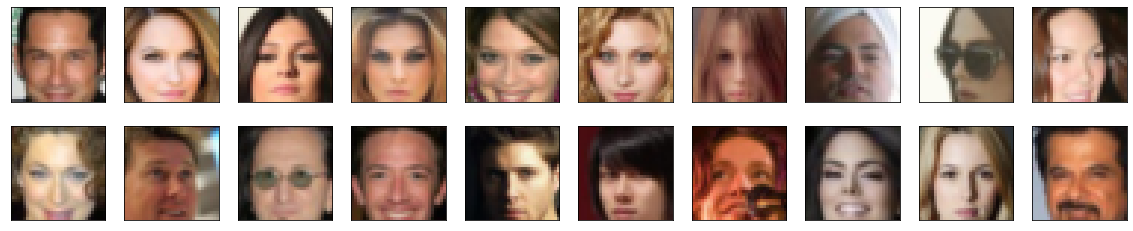

In [7]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [8]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min_val, max_val = feature_range
    scaled_x = (max_val - min_val)*x-1
    
    return scaled_x


In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9765)
Max:  tensor(0.9059)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [10]:
import torch.nn as nn
import torch.nn.functional as F

In [11]:
# function to create a convolutional layer followed by BatchNorm
def conv(in_channels, out_channels, kernel_size, stride = 2, padding = 1, batch_norm = True):
    
    bias = not batch_norm
    layers = []
    
    conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias = bias)
    layers.append(conv_layer)
    
    if batch_norm:
        batch = nn.BatchNorm2d(out_channels)
        layers.append(batch)
    
    return nn.Sequential(*layers)

In [12]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        
        # shape of input_images = (3,32,32)
        # We will create convolutional layers that transform the input image as follows
        # (3,32,32) -> (conv_dim, 16, 16) -> (2*conv_dim, 8, 8) -> (4*conv_dim, 4, 4) -> (1,1,1)
        
        # the first conv. layer will not have a batch_norm
        self.conv1 = conv(3, conv_dim, kernel_size = 4, batch_norm = False )
        # output shape =  (conv_dim, 16, 16)
        
        self.conv2 = conv(conv_dim, 2*conv_dim, kernel_size = 4)
        # output shape = (2*conv_dim, 8, 8) 
        
        self.conv3 = conv(2*conv_dim, 4*conv_dim, kernel_size = 4)
        # output shape = (4*conv_dim, 4, 4)
        
        self.conv4 = conv(4*conv_dim, 1, kernel_size = 4, stride = 1, 
                          padding = 0, batch_norm = False)
        # output shape = (1,1,1)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = self.conv4(x).view(-1,1)
        
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [13]:
# function to create a layer with transpose convolutions followed by BatchNormalization
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm = True):
    
    bias = not batch_norm
    layers = []
    
    transConv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size,  
                                   stride, padding, bias = bias)
    layers.append(transConv)
    
    if batch_norm:
        batch = nn.BatchNorm2d(out_channels)
        layers.append(batch)
        
    return nn.Sequential(*layers)    

In [14]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        self.linear = nn.Linear(z_size, 4*4*conv_dim*4)
        # we will reshape this to (4*conv_dim, 4, 4)
        # we will then pass this through convolutional layers that will transform the shape as follows
        # (4*conv_dim, 4 , 4) -> (2*conv_dim, 8 , 8) -> (conv_dim, 16 , 16) -> (3, 32, 32)
        # the last convolutional layer will not have batch normalization
        
        self.conv1 = deconv(4*conv_dim, 2*conv_dim, 4)
        self.conv2 = deconv(2*conv_dim, conv_dim, 4)
        self.conv3 = deconv(conv_dim, 3, 4, batch_norm = False)
        
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = F.relu(self.linear(x)).view(-1, 4*self.conv_dim, 4, 4)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.tanh(self.conv3(x))
        
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [15]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    
    if ('Conv' in classname) or ('Linear' in classname):
        m.weight.data.normal_(0, 0.02)
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [17]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1))
  )
)

Generator(
  (linear): Linear(in_features=100, out_features=2048, bias=True)
  (conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), paddin

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [19]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    loss = torch.mean((D_out-1)**2)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    loss = torch.mean(D_out**2)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [20]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G
lr, beta1, beta2 = 0.0002, 0.5, 0.999
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [21]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            z = np.random.uniform(-1,1, size = (batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                real_images = real_images.cuda()
                z = z.cuda()
            
            # optimizer on real images
            d_optimizer.zero_grad()
            d_real = D(real_images)
            real_d_loss = real_loss(d_real)
            
            # optimizer on fake images
            fake_images = G(z)
            d_fake = D(fake_images)
            fake_d_loss = fake_loss(d_fake)
            
            d_loss = real_d_loss + fake_d_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            z = np.random.uniform(-1, 1, size = (batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            
            gen_images = G(z)
            d_gen_images = D(gen_images)
            g_loss = real_loss(d_gen_images)
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [22]:
# set number of epochs 
n_epochs = 500


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/  500] | d_loss: 1.4347 | g_loss: 1.9801
Epoch [    1/  500] | d_loss: 0.6719 | g_loss: 3.8940
Epoch [    1/  500] | d_loss: 0.0553 | g_loss: 1.0436
Epoch [    1/  500] | d_loss: 0.0470 | g_loss: 1.1301
Epoch [    1/  500] | d_loss: 0.0498 | g_loss: 1.6657
Epoch [    1/  500] | d_loss: 0.0651 | g_loss: 1.0396
Epoch [    1/  500] | d_loss: 0.1252 | g_loss: 1.5114
Epoch [    1/  500] | d_loss: 0.1105 | g_loss: 1.2473
Epoch [    1/  500] | d_loss: 0.1274 | g_loss: 0.9529
Epoch [    1/  500] | d_loss: 0.1839 | g_loss: 0.6544
Epoch [    1/  500] | d_loss: 0.2776 | g_loss: 0.7971
Epoch [    1/  500] | d_loss: 0.2755 | g_loss: 0.4566
Epoch [    1/  500] | d_loss: 0.1714 | g_loss: 1.3985
Epoch [    1/  500] | d_loss: 0.1418 | g_loss: 0.9952
Epoch [    1/  500] | d_loss: 0.3507 | g_loss: 0.3654
Epoch [    1/  500] | d_loss: 0.2117 | g_loss: 0.7187
Epoch [    1/  500] | d_loss: 0.2798 | g_loss: 0.6262
Epoch [    1/  500] | d_loss: 0.2639 | g_loss: 0.5848
Epoch [    1/  500] | d_loss

Epoch [    6/  500] | d_loss: 0.3137 | g_loss: 0.3343
Epoch [    6/  500] | d_loss: 0.3169 | g_loss: 0.4538
Epoch [    6/  500] | d_loss: 0.6697 | g_loss: 1.5646
Epoch [    6/  500] | d_loss: 0.3826 | g_loss: 0.3532
Epoch [    6/  500] | d_loss: 0.3153 | g_loss: 0.8291
Epoch [    6/  500] | d_loss: 0.3249 | g_loss: 0.4533
Epoch [    6/  500] | d_loss: 0.3486 | g_loss: 0.6934
Epoch [    6/  500] | d_loss: 0.3006 | g_loss: 0.6429
Epoch [    6/  500] | d_loss: 0.2402 | g_loss: 0.5975
Epoch [    6/  500] | d_loss: 0.2846 | g_loss: 0.7335
Epoch [    6/  500] | d_loss: 0.2319 | g_loss: 0.4320
Epoch [    6/  500] | d_loss: 0.2670 | g_loss: 0.5726
Epoch [    6/  500] | d_loss: 0.3337 | g_loss: 0.7005
Epoch [    6/  500] | d_loss: 0.4923 | g_loss: 0.8456
Epoch [    6/  500] | d_loss: 0.2441 | g_loss: 0.6780
Epoch [    6/  500] | d_loss: 0.3400 | g_loss: 0.6069
Epoch [    6/  500] | d_loss: 0.3704 | g_loss: 0.5100
Epoch [    6/  500] | d_loss: 0.5214 | g_loss: 0.3833
Epoch [    6/  500] | d_loss

Epoch [   11/  500] | d_loss: 0.3811 | g_loss: 0.7312
Epoch [   11/  500] | d_loss: 0.2350 | g_loss: 0.6447
Epoch [   11/  500] | d_loss: 0.1883 | g_loss: 0.4290
Epoch [   11/  500] | d_loss: 0.1607 | g_loss: 0.7028
Epoch [   11/  500] | d_loss: 0.2268 | g_loss: 0.6365
Epoch [   11/  500] | d_loss: 0.2131 | g_loss: 0.8259
Epoch [   11/  500] | d_loss: 0.3039 | g_loss: 0.8828
Epoch [   11/  500] | d_loss: 0.2200 | g_loss: 0.5295
Epoch [   11/  500] | d_loss: 0.2326 | g_loss: 0.5943
Epoch [   11/  500] | d_loss: 0.3207 | g_loss: 1.2191
Epoch [   11/  500] | d_loss: 0.3677 | g_loss: 0.2200
Epoch [   11/  500] | d_loss: 0.8105 | g_loss: 1.1354
Epoch [   11/  500] | d_loss: 0.2651 | g_loss: 0.6012
Epoch [   11/  500] | d_loss: 0.2628 | g_loss: 0.5651
Epoch [   11/  500] | d_loss: 0.2051 | g_loss: 0.6555
Epoch [   12/  500] | d_loss: 0.4709 | g_loss: 0.9531
Epoch [   12/  500] | d_loss: 0.2137 | g_loss: 0.7841
Epoch [   12/  500] | d_loss: 0.4506 | g_loss: 0.0715
Epoch [   12/  500] | d_loss

Epoch [   16/  500] | d_loss: 0.2005 | g_loss: 0.6651
Epoch [   16/  500] | d_loss: 0.1718 | g_loss: 0.7732
Epoch [   16/  500] | d_loss: 0.2113 | g_loss: 0.6140
Epoch [   16/  500] | d_loss: 0.1528 | g_loss: 0.6916
Epoch [   16/  500] | d_loss: 0.2419 | g_loss: 1.0287
Epoch [   16/  500] | d_loss: 0.6150 | g_loss: 0.2948
Epoch [   16/  500] | d_loss: 0.5058 | g_loss: 0.3718
Epoch [   16/  500] | d_loss: 0.3104 | g_loss: 0.4583
Epoch [   17/  500] | d_loss: 0.4655 | g_loss: 0.6925
Epoch [   17/  500] | d_loss: 0.2248 | g_loss: 0.7711
Epoch [   17/  500] | d_loss: 0.1801 | g_loss: 0.5443
Epoch [   17/  500] | d_loss: 0.2198 | g_loss: 0.5721
Epoch [   17/  500] | d_loss: 0.1730 | g_loss: 0.6206
Epoch [   17/  500] | d_loss: 0.1602 | g_loss: 1.0409
Epoch [   17/  500] | d_loss: 0.1991 | g_loss: 0.6402
Epoch [   17/  500] | d_loss: 0.1253 | g_loss: 0.5745
Epoch [   17/  500] | d_loss: 0.1420 | g_loss: 0.5970
Epoch [   17/  500] | d_loss: 0.2978 | g_loss: 0.3015
Epoch [   17/  500] | d_loss

Epoch [   21/  500] | d_loss: 0.1189 | g_loss: 0.7255
Epoch [   22/  500] | d_loss: 0.1301 | g_loss: 0.6333
Epoch [   22/  500] | d_loss: 0.0882 | g_loss: 0.7376
Epoch [   22/  500] | d_loss: 0.1202 | g_loss: 0.6653
Epoch [   22/  500] | d_loss: 0.0825 | g_loss: 0.9560
Epoch [   22/  500] | d_loss: 0.2147 | g_loss: 0.8029
Epoch [   22/  500] | d_loss: 0.1561 | g_loss: 1.0354
Epoch [   22/  500] | d_loss: 0.0919 | g_loss: 0.7060
Epoch [   22/  500] | d_loss: 0.1588 | g_loss: 0.4447
Epoch [   22/  500] | d_loss: 0.3467 | g_loss: 1.1640
Epoch [   22/  500] | d_loss: 0.3196 | g_loss: 1.6250
Epoch [   22/  500] | d_loss: 0.1246 | g_loss: 0.6197
Epoch [   22/  500] | d_loss: 0.1138 | g_loss: 0.5948
Epoch [   22/  500] | d_loss: 0.1240 | g_loss: 0.5096
Epoch [   22/  500] | d_loss: 0.2177 | g_loss: 0.4019
Epoch [   22/  500] | d_loss: 0.4158 | g_loss: 0.2691
Epoch [   22/  500] | d_loss: 0.0979 | g_loss: 0.6221
Epoch [   22/  500] | d_loss: 0.8630 | g_loss: 1.9240
Epoch [   22/  500] | d_loss

Epoch [   27/  500] | d_loss: 0.1923 | g_loss: 0.9506
Epoch [   27/  500] | d_loss: 0.1036 | g_loss: 0.9008
Epoch [   27/  500] | d_loss: 0.0737 | g_loss: 0.6548
Epoch [   27/  500] | d_loss: 0.0991 | g_loss: 0.9896
Epoch [   27/  500] | d_loss: 0.1217 | g_loss: 0.6107
Epoch [   27/  500] | d_loss: 0.0920 | g_loss: 0.8220
Epoch [   27/  500] | d_loss: 0.2029 | g_loss: 1.1220
Epoch [   27/  500] | d_loss: 0.1050 | g_loss: 0.8360
Epoch [   27/  500] | d_loss: 0.0811 | g_loss: 0.9576
Epoch [   27/  500] | d_loss: 0.1501 | g_loss: 0.7038
Epoch [   27/  500] | d_loss: 0.1535 | g_loss: 0.5381
Epoch [   27/  500] | d_loss: 0.1253 | g_loss: 0.8056
Epoch [   27/  500] | d_loss: 0.1559 | g_loss: 0.7143
Epoch [   27/  500] | d_loss: 0.2354 | g_loss: 1.3444
Epoch [   27/  500] | d_loss: 0.1156 | g_loss: 1.0795
Epoch [   27/  500] | d_loss: 0.0776 | g_loss: 0.8700
Epoch [   27/  500] | d_loss: 0.2087 | g_loss: 0.7859
Epoch [   27/  500] | d_loss: 0.1544 | g_loss: 0.6955
Epoch [   27/  500] | d_loss

Epoch [   32/  500] | d_loss: 0.1426 | g_loss: 0.7543
Epoch [   32/  500] | d_loss: 0.0612 | g_loss: 1.0111
Epoch [   32/  500] | d_loss: 0.1124 | g_loss: 0.8050
Epoch [   32/  500] | d_loss: 0.0545 | g_loss: 0.6999
Epoch [   32/  500] | d_loss: 0.1006 | g_loss: 0.9986
Epoch [   32/  500] | d_loss: 0.1526 | g_loss: 0.9852
Epoch [   32/  500] | d_loss: 0.3669 | g_loss: 0.5444
Epoch [   32/  500] | d_loss: 0.1457 | g_loss: 1.1639
Epoch [   32/  500] | d_loss: 0.0719 | g_loss: 0.9832
Epoch [   32/  500] | d_loss: 0.0673 | g_loss: 0.9331
Epoch [   32/  500] | d_loss: 0.0788 | g_loss: 0.7097
Epoch [   32/  500] | d_loss: 0.0519 | g_loss: 0.8542
Epoch [   32/  500] | d_loss: 0.1349 | g_loss: 0.8617
Epoch [   32/  500] | d_loss: 0.1319 | g_loss: 0.8369
Epoch [   32/  500] | d_loss: 0.1191 | g_loss: 1.1212
Epoch [   32/  500] | d_loss: 0.0820 | g_loss: 0.7757
Epoch [   33/  500] | d_loss: 0.2198 | g_loss: 0.8960
Epoch [   33/  500] | d_loss: 0.1006 | g_loss: 0.7026
Epoch [   33/  500] | d_loss

Epoch [   37/  500] | d_loss: 0.0409 | g_loss: 1.1279
Epoch [   37/  500] | d_loss: 0.1022 | g_loss: 0.5996
Epoch [   37/  500] | d_loss: 0.1107 | g_loss: 0.5603
Epoch [   37/  500] | d_loss: 0.2175 | g_loss: 0.4950
Epoch [   37/  500] | d_loss: 0.1450 | g_loss: 0.7975
Epoch [   37/  500] | d_loss: 0.0928 | g_loss: 0.9773
Epoch [   37/  500] | d_loss: 0.0755 | g_loss: 0.9055
Epoch [   37/  500] | d_loss: 0.0859 | g_loss: 0.9095
Epoch [   37/  500] | d_loss: 0.0591 | g_loss: 1.0594
Epoch [   38/  500] | d_loss: 0.1114 | g_loss: 1.0171
Epoch [   38/  500] | d_loss: 0.1320 | g_loss: 0.5775
Epoch [   38/  500] | d_loss: 0.0504 | g_loss: 0.9818
Epoch [   38/  500] | d_loss: 0.1445 | g_loss: 1.5279
Epoch [   38/  500] | d_loss: 0.1269 | g_loss: 0.8874
Epoch [   38/  500] | d_loss: 0.2344 | g_loss: 0.4459
Epoch [   38/  500] | d_loss: 0.0736 | g_loss: 1.0181
Epoch [   38/  500] | d_loss: 0.0948 | g_loss: 0.4831
Epoch [   38/  500] | d_loss: 0.1485 | g_loss: 1.5047
Epoch [   38/  500] | d_loss

Epoch [   42/  500] | d_loss: 0.0942 | g_loss: 1.0379
Epoch [   42/  500] | d_loss: 0.0973 | g_loss: 0.8674
Epoch [   43/  500] | d_loss: 0.2160 | g_loss: 0.6323
Epoch [   43/  500] | d_loss: 0.0857 | g_loss: 0.7725
Epoch [   43/  500] | d_loss: 0.0655 | g_loss: 1.1133
Epoch [   43/  500] | d_loss: 0.1103 | g_loss: 0.8758
Epoch [   43/  500] | d_loss: 0.0685 | g_loss: 0.6990
Epoch [   43/  500] | d_loss: 0.1058 | g_loss: 0.8320
Epoch [   43/  500] | d_loss: 0.0740 | g_loss: 0.8127
Epoch [   43/  500] | d_loss: 0.4598 | g_loss: 0.3780
Epoch [   43/  500] | d_loss: 0.1373 | g_loss: 0.5845
Epoch [   43/  500] | d_loss: 0.0781 | g_loss: 0.8473
Epoch [   43/  500] | d_loss: 0.1247 | g_loss: 1.2303
Epoch [   43/  500] | d_loss: 0.0579 | g_loss: 1.1030
Epoch [   43/  500] | d_loss: 0.0513 | g_loss: 0.7753
Epoch [   43/  500] | d_loss: 0.0685 | g_loss: 1.0050
Epoch [   43/  500] | d_loss: 0.0839 | g_loss: 0.6372
Epoch [   43/  500] | d_loss: 0.1153 | g_loss: 0.7624
Epoch [   43/  500] | d_loss

Epoch [   48/  500] | d_loss: 0.0618 | g_loss: 0.9309
Epoch [   48/  500] | d_loss: 0.0505 | g_loss: 0.8227
Epoch [   48/  500] | d_loss: 0.0542 | g_loss: 0.7389
Epoch [   48/  500] | d_loss: 0.1359 | g_loss: 1.0062
Epoch [   48/  500] | d_loss: 0.0483 | g_loss: 1.2740
Epoch [   48/  500] | d_loss: 0.0382 | g_loss: 1.0070
Epoch [   48/  500] | d_loss: 0.0741 | g_loss: 0.5629
Epoch [   48/  500] | d_loss: 0.0522 | g_loss: 1.2662
Epoch [   48/  500] | d_loss: 0.5135 | g_loss: 0.1767
Epoch [   48/  500] | d_loss: 0.1935 | g_loss: 0.7969
Epoch [   48/  500] | d_loss: 0.1168 | g_loss: 0.5405
Epoch [   48/  500] | d_loss: 0.0838 | g_loss: 0.5492
Epoch [   48/  500] | d_loss: 0.0714 | g_loss: 0.8489
Epoch [   48/  500] | d_loss: 0.1831 | g_loss: 1.2192
Epoch [   48/  500] | d_loss: 0.1644 | g_loss: 1.0611
Epoch [   48/  500] | d_loss: 0.0779 | g_loss: 0.5028
Epoch [   48/  500] | d_loss: 0.1604 | g_loss: 0.8564
Epoch [   48/  500] | d_loss: 0.0875 | g_loss: 0.5434
Epoch [   48/  500] | d_loss

Epoch [   53/  500] | d_loss: 0.1241 | g_loss: 0.7429
Epoch [   53/  500] | d_loss: 0.0576 | g_loss: 0.9638
Epoch [   53/  500] | d_loss: 0.0843 | g_loss: 0.7428
Epoch [   53/  500] | d_loss: 0.0762 | g_loss: 1.1788
Epoch [   53/  500] | d_loss: 0.0741 | g_loss: 0.4497
Epoch [   53/  500] | d_loss: 0.0803 | g_loss: 0.7121
Epoch [   53/  500] | d_loss: 0.0536 | g_loss: 0.5859
Epoch [   53/  500] | d_loss: 0.0664 | g_loss: 1.0496
Epoch [   53/  500] | d_loss: 0.0448 | g_loss: 0.6415
Epoch [   53/  500] | d_loss: 0.0704 | g_loss: 0.7849
Epoch [   53/  500] | d_loss: 0.0513 | g_loss: 1.0247
Epoch [   53/  500] | d_loss: 0.0550 | g_loss: 0.9458
Epoch [   53/  500] | d_loss: 0.0958 | g_loss: 1.3231
Epoch [   53/  500] | d_loss: 0.0647 | g_loss: 0.7023
Epoch [   53/  500] | d_loss: 0.0668 | g_loss: 1.0055
Epoch [   53/  500] | d_loss: 0.0701 | g_loss: 0.9772
Epoch [   53/  500] | d_loss: 0.0579 | g_loss: 0.9299
Epoch [   54/  500] | d_loss: 0.1923 | g_loss: 2.0583
Epoch [   54/  500] | d_loss

Epoch [   58/  500] | d_loss: 0.0370 | g_loss: 0.9995
Epoch [   58/  500] | d_loss: 0.0392 | g_loss: 0.9060
Epoch [   58/  500] | d_loss: 0.0675 | g_loss: 1.0142
Epoch [   58/  500] | d_loss: 0.0599 | g_loss: 0.7323
Epoch [   58/  500] | d_loss: 0.0600 | g_loss: 0.8969
Epoch [   58/  500] | d_loss: 0.4434 | g_loss: 0.1377
Epoch [   58/  500] | d_loss: 0.5149 | g_loss: 0.3957
Epoch [   58/  500] | d_loss: 0.4745 | g_loss: 0.2498
Epoch [   58/  500] | d_loss: 0.5461 | g_loss: 0.1617
Epoch [   58/  500] | d_loss: 0.1066 | g_loss: 1.0866
Epoch [   59/  500] | d_loss: 0.3735 | g_loss: 1.2806
Epoch [   59/  500] | d_loss: 0.0966 | g_loss: 0.8503
Epoch [   59/  500] | d_loss: 0.0965 | g_loss: 0.6847
Epoch [   59/  500] | d_loss: 0.0806 | g_loss: 1.0396
Epoch [   59/  500] | d_loss: 0.0592 | g_loss: 0.9634
Epoch [   59/  500] | d_loss: 0.0435 | g_loss: 0.7899
Epoch [   59/  500] | d_loss: 0.0629 | g_loss: 1.1370
Epoch [   59/  500] | d_loss: 0.0627 | g_loss: 1.0535
Epoch [   59/  500] | d_loss

Epoch [   63/  500] | d_loss: 0.0540 | g_loss: 1.1456
Epoch [   63/  500] | d_loss: 0.0797 | g_loss: 1.1009
Epoch [   63/  500] | d_loss: 0.0746 | g_loss: 0.8065
Epoch [   64/  500] | d_loss: 0.1664 | g_loss: 1.0443
Epoch [   64/  500] | d_loss: 0.0372 | g_loss: 1.2068
Epoch [   64/  500] | d_loss: 0.0636 | g_loss: 0.8169
Epoch [   64/  500] | d_loss: 0.0567 | g_loss: 0.8774
Epoch [   64/  500] | d_loss: 0.1039 | g_loss: 1.0278
Epoch [   64/  500] | d_loss: 0.2002 | g_loss: 0.9444
Epoch [   64/  500] | d_loss: 0.1558 | g_loss: 1.0654
Epoch [   64/  500] | d_loss: 0.0637 | g_loss: 0.7350
Epoch [   64/  500] | d_loss: 0.2048 | g_loss: 1.4739
Epoch [   64/  500] | d_loss: 0.0674 | g_loss: 0.8676
Epoch [   64/  500] | d_loss: 0.0574 | g_loss: 0.9594
Epoch [   64/  500] | d_loss: 0.0726 | g_loss: 0.7474
Epoch [   64/  500] | d_loss: 0.0377 | g_loss: 1.3930
Epoch [   64/  500] | d_loss: 0.1227 | g_loss: 0.6750
Epoch [   64/  500] | d_loss: 0.1688 | g_loss: 0.9377
Epoch [   64/  500] | d_loss

Epoch [   69/  500] | d_loss: 0.5018 | g_loss: 0.0623
Epoch [   69/  500] | d_loss: 0.4733 | g_loss: 0.3368
Epoch [   69/  500] | d_loss: 0.1871 | g_loss: 0.9697
Epoch [   69/  500] | d_loss: 0.0588 | g_loss: 0.8895
Epoch [   69/  500] | d_loss: 0.0625 | g_loss: 1.0412
Epoch [   69/  500] | d_loss: 0.0430 | g_loss: 0.8710
Epoch [   69/  500] | d_loss: 0.0933 | g_loss: 1.1052
Epoch [   69/  500] | d_loss: 0.0449 | g_loss: 0.9994
Epoch [   69/  500] | d_loss: 0.0269 | g_loss: 1.1672
Epoch [   69/  500] | d_loss: 0.1384 | g_loss: 1.2850
Epoch [   69/  500] | d_loss: 0.0661 | g_loss: 0.6115
Epoch [   69/  500] | d_loss: 0.0686 | g_loss: 0.7023
Epoch [   69/  500] | d_loss: 0.1415 | g_loss: 0.9953
Epoch [   69/  500] | d_loss: 0.0509 | g_loss: 0.7799
Epoch [   69/  500] | d_loss: 0.0729 | g_loss: 0.5996
Epoch [   69/  500] | d_loss: 0.1298 | g_loss: 0.7515
Epoch [   69/  500] | d_loss: 0.1281 | g_loss: 0.4348
Epoch [   69/  500] | d_loss: 0.1005 | g_loss: 0.6366
Epoch [   69/  500] | d_loss

Epoch [   74/  500] | d_loss: 0.0451 | g_loss: 1.1451
Epoch [   74/  500] | d_loss: 0.1477 | g_loss: 0.8090
Epoch [   74/  500] | d_loss: 0.1951 | g_loss: 1.0318
Epoch [   74/  500] | d_loss: 0.0820 | g_loss: 1.3896
Epoch [   74/  500] | d_loss: 0.0375 | g_loss: 0.8493
Epoch [   74/  500] | d_loss: 0.0672 | g_loss: 1.0607
Epoch [   74/  500] | d_loss: 0.0519 | g_loss: 0.7655
Epoch [   74/  500] | d_loss: 0.0511 | g_loss: 0.9452
Epoch [   74/  500] | d_loss: 0.0462 | g_loss: 0.7972
Epoch [   74/  500] | d_loss: 0.0639 | g_loss: 0.9798
Epoch [   74/  500] | d_loss: 0.0597 | g_loss: 0.6621
Epoch [   74/  500] | d_loss: 0.0814 | g_loss: 0.7153
Epoch [   74/  500] | d_loss: 0.0801 | g_loss: 1.2459
Epoch [   74/  500] | d_loss: 0.0682 | g_loss: 0.8140
Epoch [   74/  500] | d_loss: 0.1282 | g_loss: 0.8626
Epoch [   74/  500] | d_loss: 0.1925 | g_loss: 0.7552
Epoch [   74/  500] | d_loss: 0.5935 | g_loss: 0.5811
Epoch [   74/  500] | d_loss: 0.1404 | g_loss: 0.8335
Epoch [   75/  500] | d_loss

Epoch [   79/  500] | d_loss: 0.0586 | g_loss: 1.1513
Epoch [   79/  500] | d_loss: 0.0588 | g_loss: 0.9423
Epoch [   79/  500] | d_loss: 0.1097 | g_loss: 0.8647
Epoch [   79/  500] | d_loss: 0.0391 | g_loss: 0.7264
Epoch [   79/  500] | d_loss: 0.0581 | g_loss: 0.9983
Epoch [   79/  500] | d_loss: 0.1199 | g_loss: 0.8145
Epoch [   79/  500] | d_loss: 0.2490 | g_loss: 0.6548
Epoch [   79/  500] | d_loss: 0.0529 | g_loss: 0.9327
Epoch [   79/  500] | d_loss: 0.0598 | g_loss: 1.1487
Epoch [   79/  500] | d_loss: 0.0443 | g_loss: 1.2645
Epoch [   79/  500] | d_loss: 0.0485 | g_loss: 0.9677
Epoch [   80/  500] | d_loss: 0.1498 | g_loss: 1.1112
Epoch [   80/  500] | d_loss: 0.0693 | g_loss: 1.0498
Epoch [   80/  500] | d_loss: 0.0669 | g_loss: 0.7784
Epoch [   80/  500] | d_loss: 0.1269 | g_loss: 0.9282
Epoch [   80/  500] | d_loss: 0.0603 | g_loss: 1.0889
Epoch [   80/  500] | d_loss: 0.0725 | g_loss: 0.6357
Epoch [   80/  500] | d_loss: 0.0557 | g_loss: 0.7938
Epoch [   80/  500] | d_loss

Epoch [   84/  500] | d_loss: 0.0528 | g_loss: 0.9215
Epoch [   84/  500] | d_loss: 0.5246 | g_loss: 0.2693
Epoch [   84/  500] | d_loss: 0.1054 | g_loss: 1.1894
Epoch [   84/  500] | d_loss: 0.0711 | g_loss: 0.9134
Epoch [   85/  500] | d_loss: 0.1068 | g_loss: 0.7186
Epoch [   85/  500] | d_loss: 0.0991 | g_loss: 1.2324
Epoch [   85/  500] | d_loss: 0.0409 | g_loss: 1.1646
Epoch [   85/  500] | d_loss: 0.0918 | g_loss: 1.1693
Epoch [   85/  500] | d_loss: 0.1029 | g_loss: 0.9663
Epoch [   85/  500] | d_loss: 0.1145 | g_loss: 1.0616
Epoch [   85/  500] | d_loss: 0.0466 | g_loss: 0.9492
Epoch [   85/  500] | d_loss: 0.0569 | g_loss: 1.1337
Epoch [   85/  500] | d_loss: 0.0870 | g_loss: 1.1497
Epoch [   85/  500] | d_loss: 0.0440 | g_loss: 0.8331
Epoch [   85/  500] | d_loss: 0.0453 | g_loss: 1.1134
Epoch [   85/  500] | d_loss: 0.0733 | g_loss: 1.1117
Epoch [   85/  500] | d_loss: 0.0360 | g_loss: 1.0370
Epoch [   85/  500] | d_loss: 0.0236 | g_loss: 0.8224
Epoch [   85/  500] | d_loss

Epoch [   90/  500] | d_loss: 0.0550 | g_loss: 0.5956
Epoch [   90/  500] | d_loss: 0.0444 | g_loss: 0.9313
Epoch [   90/  500] | d_loss: 0.0364 | g_loss: 1.0359
Epoch [   90/  500] | d_loss: 0.0523 | g_loss: 0.8276
Epoch [   90/  500] | d_loss: 0.0318 | g_loss: 1.0677
Epoch [   90/  500] | d_loss: 0.0387 | g_loss: 0.8847
Epoch [   90/  500] | d_loss: 0.0922 | g_loss: 1.1476
Epoch [   90/  500] | d_loss: 0.1199 | g_loss: 0.7956
Epoch [   90/  500] | d_loss: 0.0376 | g_loss: 1.1136
Epoch [   90/  500] | d_loss: 0.0631 | g_loss: 1.0023
Epoch [   90/  500] | d_loss: 0.0422 | g_loss: 0.8966
Epoch [   90/  500] | d_loss: 0.0491 | g_loss: 0.9597
Epoch [   90/  500] | d_loss: 0.0987 | g_loss: 0.6619
Epoch [   90/  500] | d_loss: 0.0635 | g_loss: 0.8586
Epoch [   90/  500] | d_loss: 0.0583 | g_loss: 0.6866
Epoch [   90/  500] | d_loss: 0.0806 | g_loss: 0.9767
Epoch [   90/  500] | d_loss: 0.0597 | g_loss: 0.7078
Epoch [   90/  500] | d_loss: 0.1646 | g_loss: 0.7493
Epoch [   90/  500] | d_loss

Epoch [   95/  500] | d_loss: 0.0447 | g_loss: 0.5633
Epoch [   95/  500] | d_loss: 0.0762 | g_loss: 0.5753
Epoch [   95/  500] | d_loss: 0.0584 | g_loss: 0.8589
Epoch [   95/  500] | d_loss: 0.0367 | g_loss: 0.8385
Epoch [   95/  500] | d_loss: 0.0854 | g_loss: 1.0076
Epoch [   95/  500] | d_loss: 0.3180 | g_loss: 0.5020
Epoch [   95/  500] | d_loss: 0.0947 | g_loss: 0.6916
Epoch [   95/  500] | d_loss: 0.0773 | g_loss: 1.1391
Epoch [   95/  500] | d_loss: 0.0606 | g_loss: 0.8410
Epoch [   95/  500] | d_loss: 0.1493 | g_loss: 0.6480
Epoch [   95/  500] | d_loss: 0.1134 | g_loss: 0.8143
Epoch [   95/  500] | d_loss: 0.0561 | g_loss: 0.6807
Epoch [   95/  500] | d_loss: 0.0791 | g_loss: 0.9039
Epoch [   95/  500] | d_loss: 0.0543 | g_loss: 0.8361
Epoch [   95/  500] | d_loss: 0.0641 | g_loss: 0.7310
Epoch [   95/  500] | d_loss: 0.0489 | g_loss: 1.0476
Epoch [   95/  500] | d_loss: 0.0394 | g_loss: 1.0785
Epoch [   95/  500] | d_loss: 0.0428 | g_loss: 1.0726
Epoch [   95/  500] | d_loss

Epoch [  100/  500] | d_loss: 0.0357 | g_loss: 0.9003
Epoch [  100/  500] | d_loss: 0.0615 | g_loss: 0.9651
Epoch [  100/  500] | d_loss: 0.0689 | g_loss: 0.8344
Epoch [  100/  500] | d_loss: 0.0363 | g_loss: 0.9146
Epoch [  100/  500] | d_loss: 0.1257 | g_loss: 0.7674
Epoch [  100/  500] | d_loss: 0.1512 | g_loss: 1.1304
Epoch [  100/  500] | d_loss: 0.0800 | g_loss: 0.9885
Epoch [  100/  500] | d_loss: 0.0970 | g_loss: 1.3960
Epoch [  100/  500] | d_loss: 0.1217 | g_loss: 1.4153
Epoch [  100/  500] | d_loss: 0.0517 | g_loss: 1.0759
Epoch [  100/  500] | d_loss: 0.0779 | g_loss: 0.5755
Epoch [  100/  500] | d_loss: 0.1179 | g_loss: 0.5935
Epoch [  101/  500] | d_loss: 0.5657 | g_loss: 1.6176
Epoch [  101/  500] | d_loss: 0.0353 | g_loss: 1.1134
Epoch [  101/  500] | d_loss: 0.0478 | g_loss: 0.8383
Epoch [  101/  500] | d_loss: 0.0625 | g_loss: 1.0942
Epoch [  101/  500] | d_loss: 0.0448 | g_loss: 1.0612
Epoch [  101/  500] | d_loss: 0.0752 | g_loss: 0.8031
Epoch [  101/  500] | d_loss

Epoch [  105/  500] | d_loss: 0.0921 | g_loss: 0.8268
Epoch [  105/  500] | d_loss: 0.0385 | g_loss: 1.1945
Epoch [  105/  500] | d_loss: 0.0360 | g_loss: 1.0147
Epoch [  105/  500] | d_loss: 0.0785 | g_loss: 0.7774
Epoch [  105/  500] | d_loss: 0.0528 | g_loss: 0.5556
Epoch [  106/  500] | d_loss: 0.1054 | g_loss: 0.9243
Epoch [  106/  500] | d_loss: 0.0622 | g_loss: 1.0170
Epoch [  106/  500] | d_loss: 0.1473 | g_loss: 0.7470
Epoch [  106/  500] | d_loss: 0.0366 | g_loss: 1.2663
Epoch [  106/  500] | d_loss: 0.0270 | g_loss: 1.0839
Epoch [  106/  500] | d_loss: 0.0606 | g_loss: 0.8016
Epoch [  106/  500] | d_loss: 0.0493 | g_loss: 0.9156
Epoch [  106/  500] | d_loss: 0.1670 | g_loss: 0.6557
Epoch [  106/  500] | d_loss: 0.0348 | g_loss: 0.7992
Epoch [  106/  500] | d_loss: 0.0986 | g_loss: 0.7590
Epoch [  106/  500] | d_loss: 0.1602 | g_loss: 0.8890
Epoch [  106/  500] | d_loss: 0.0429 | g_loss: 0.7561
Epoch [  106/  500] | d_loss: 0.0472 | g_loss: 1.0688
Epoch [  106/  500] | d_loss

Epoch [  111/  500] | d_loss: 0.1313 | g_loss: 0.6634
Epoch [  111/  500] | d_loss: 0.0978 | g_loss: 0.8499
Epoch [  111/  500] | d_loss: 0.0560 | g_loss: 0.9601
Epoch [  111/  500] | d_loss: 0.1059 | g_loss: 1.3280
Epoch [  111/  500] | d_loss: 0.0561 | g_loss: 0.7995
Epoch [  111/  500] | d_loss: 0.0905 | g_loss: 0.9365
Epoch [  111/  500] | d_loss: 0.0685 | g_loss: 1.2457
Epoch [  111/  500] | d_loss: 0.0867 | g_loss: 0.9100
Epoch [  111/  500] | d_loss: 0.0484 | g_loss: 0.9702
Epoch [  111/  500] | d_loss: 0.0731 | g_loss: 1.1948
Epoch [  111/  500] | d_loss: 0.0799 | g_loss: 0.7937
Epoch [  111/  500] | d_loss: 0.1399 | g_loss: 0.7360
Epoch [  111/  500] | d_loss: 0.0792 | g_loss: 0.8562
Epoch [  111/  500] | d_loss: 0.0646 | g_loss: 1.1353
Epoch [  111/  500] | d_loss: 0.1066 | g_loss: 0.8728
Epoch [  111/  500] | d_loss: 0.0754 | g_loss: 0.8468
Epoch [  111/  500] | d_loss: 0.0459 | g_loss: 0.9749
Epoch [  111/  500] | d_loss: 0.0875 | g_loss: 0.9193
Epoch [  111/  500] | d_loss

Epoch [  116/  500] | d_loss: 0.1283 | g_loss: 1.1239
Epoch [  116/  500] | d_loss: 0.0185 | g_loss: 1.0575
Epoch [  116/  500] | d_loss: 0.1099 | g_loss: 1.0512
Epoch [  116/  500] | d_loss: 0.0616 | g_loss: 1.2619
Epoch [  116/  500] | d_loss: 0.0280 | g_loss: 0.7238
Epoch [  116/  500] | d_loss: 0.0461 | g_loss: 0.7220
Epoch [  116/  500] | d_loss: 0.0836 | g_loss: 0.8907
Epoch [  116/  500] | d_loss: 0.0554 | g_loss: 1.2915
Epoch [  116/  500] | d_loss: 0.0856 | g_loss: 0.7566
Epoch [  116/  500] | d_loss: 0.0744 | g_loss: 0.8131
Epoch [  116/  500] | d_loss: 0.0303 | g_loss: 0.9924
Epoch [  116/  500] | d_loss: 0.0419 | g_loss: 0.6121
Epoch [  116/  500] | d_loss: 0.4358 | g_loss: 0.2360
Epoch [  116/  500] | d_loss: 0.0353 | g_loss: 0.9720
Epoch [  116/  500] | d_loss: 0.0914 | g_loss: 1.2768
Epoch [  116/  500] | d_loss: 0.1831 | g_loss: 0.7630
Epoch [  116/  500] | d_loss: 0.1387 | g_loss: 0.8358
Epoch [  116/  500] | d_loss: 0.0342 | g_loss: 0.5862
Epoch [  116/  500] | d_loss

Epoch [  121/  500] | d_loss: 0.0377 | g_loss: 0.9965
Epoch [  121/  500] | d_loss: 0.0479 | g_loss: 0.5449
Epoch [  121/  500] | d_loss: 0.0623 | g_loss: 1.0412
Epoch [  121/  500] | d_loss: 0.1256 | g_loss: 0.7352
Epoch [  121/  500] | d_loss: 0.0434 | g_loss: 0.9825
Epoch [  121/  500] | d_loss: 0.0320 | g_loss: 0.5859
Epoch [  121/  500] | d_loss: 0.0455 | g_loss: 0.9636
Epoch [  121/  500] | d_loss: 0.1085 | g_loss: 0.5505
Epoch [  121/  500] | d_loss: 0.0300 | g_loss: 0.8382
Epoch [  121/  500] | d_loss: 0.0479 | g_loss: 0.9192
Epoch [  121/  500] | d_loss: 0.0515 | g_loss: 0.7785
Epoch [  121/  500] | d_loss: 0.0476 | g_loss: 1.1495
Epoch [  121/  500] | d_loss: 0.0678 | g_loss: 0.9961
Epoch [  122/  500] | d_loss: 0.1927 | g_loss: 0.5850
Epoch [  122/  500] | d_loss: 0.0772 | g_loss: 0.9564
Epoch [  122/  500] | d_loss: 0.1201 | g_loss: 1.1929
Epoch [  122/  500] | d_loss: 0.1759 | g_loss: 1.2871
Epoch [  122/  500] | d_loss: 0.0343 | g_loss: 0.9361
Epoch [  122/  500] | d_loss

Epoch [  126/  500] | d_loss: 0.0424 | g_loss: 0.9214
Epoch [  126/  500] | d_loss: 0.0608 | g_loss: 1.0573
Epoch [  126/  500] | d_loss: 0.0488 | g_loss: 0.7094
Epoch [  126/  500] | d_loss: 0.1151 | g_loss: 0.7722
Epoch [  126/  500] | d_loss: 0.0961 | g_loss: 1.1987
Epoch [  126/  500] | d_loss: 0.0710 | g_loss: 0.7068
Epoch [  127/  500] | d_loss: 0.1277 | g_loss: 1.3019
Epoch [  127/  500] | d_loss: 0.0906 | g_loss: 0.9181
Epoch [  127/  500] | d_loss: 0.0339 | g_loss: 0.8563
Epoch [  127/  500] | d_loss: 0.0433 | g_loss: 0.9748
Epoch [  127/  500] | d_loss: 0.0790 | g_loss: 0.6005
Epoch [  127/  500] | d_loss: 0.0288 | g_loss: 1.1342
Epoch [  127/  500] | d_loss: 0.0916 | g_loss: 1.0772
Epoch [  127/  500] | d_loss: 0.2466 | g_loss: 0.2235
Epoch [  127/  500] | d_loss: 0.0675 | g_loss: 0.9796
Epoch [  127/  500] | d_loss: 0.0830 | g_loss: 1.0985
Epoch [  127/  500] | d_loss: 0.0853 | g_loss: 1.0173
Epoch [  127/  500] | d_loss: 0.0694 | g_loss: 1.0163
Epoch [  127/  500] | d_loss

Epoch [  132/  500] | d_loss: 0.0662 | g_loss: 0.6198
Epoch [  132/  500] | d_loss: 0.0405 | g_loss: 0.9444
Epoch [  132/  500] | d_loss: 0.0456 | g_loss: 0.8496
Epoch [  132/  500] | d_loss: 0.0950 | g_loss: 0.7609
Epoch [  132/  500] | d_loss: 0.1494 | g_loss: 0.6843
Epoch [  132/  500] | d_loss: 0.0839 | g_loss: 0.8104
Epoch [  132/  500] | d_loss: 0.0829 | g_loss: 1.3089
Epoch [  132/  500] | d_loss: 0.0399 | g_loss: 0.8106
Epoch [  132/  500] | d_loss: 0.4563 | g_loss: 0.8265
Epoch [  132/  500] | d_loss: 0.0348 | g_loss: 1.0150
Epoch [  132/  500] | d_loss: 0.0424 | g_loss: 1.2077
Epoch [  132/  500] | d_loss: 0.0748 | g_loss: 0.7705
Epoch [  132/  500] | d_loss: 0.0528 | g_loss: 0.8373
Epoch [  132/  500] | d_loss: 0.0706 | g_loss: 0.6236
Epoch [  132/  500] | d_loss: 0.0430 | g_loss: 1.0607
Epoch [  132/  500] | d_loss: 0.0494 | g_loss: 0.7721
Epoch [  132/  500] | d_loss: 0.4342 | g_loss: 0.1039
Epoch [  132/  500] | d_loss: 0.0353 | g_loss: 0.8424
Epoch [  132/  500] | d_loss

Epoch [  137/  500] | d_loss: 0.0741 | g_loss: 1.1180
Epoch [  137/  500] | d_loss: 0.1087 | g_loss: 0.7480
Epoch [  137/  500] | d_loss: 0.0505 | g_loss: 0.6818
Epoch [  137/  500] | d_loss: 0.0399 | g_loss: 0.9055
Epoch [  137/  500] | d_loss: 0.0526 | g_loss: 0.8473
Epoch [  137/  500] | d_loss: 0.0811 | g_loss: 1.1205
Epoch [  137/  500] | d_loss: 0.0568 | g_loss: 1.0540
Epoch [  137/  500] | d_loss: 0.0284 | g_loss: 1.5252
Epoch [  137/  500] | d_loss: 0.0382 | g_loss: 1.0884
Epoch [  137/  500] | d_loss: 0.0972 | g_loss: 1.4807
Epoch [  137/  500] | d_loss: 0.0481 | g_loss: 1.0639
Epoch [  137/  500] | d_loss: 0.0468 | g_loss: 0.8569
Epoch [  137/  500] | d_loss: 0.1023 | g_loss: 0.7649
Epoch [  137/  500] | d_loss: 0.0500 | g_loss: 0.8785
Epoch [  137/  500] | d_loss: 0.0591 | g_loss: 1.5628
Epoch [  137/  500] | d_loss: 0.0735 | g_loss: 0.9652
Epoch [  137/  500] | d_loss: 0.0411 | g_loss: 0.7872
Epoch [  137/  500] | d_loss: 0.0828 | g_loss: 0.9296
Epoch [  137/  500] | d_loss

Epoch [  142/  500] | d_loss: 0.0506 | g_loss: 1.0809
Epoch [  142/  500] | d_loss: 0.0411 | g_loss: 0.9752
Epoch [  142/  500] | d_loss: 0.0485 | g_loss: 0.9890
Epoch [  142/  500] | d_loss: 0.0353 | g_loss: 1.6299
Epoch [  142/  500] | d_loss: 0.0689 | g_loss: 0.8865
Epoch [  142/  500] | d_loss: 0.0441 | g_loss: 1.1677
Epoch [  142/  500] | d_loss: 0.2168 | g_loss: 0.8348
Epoch [  142/  500] | d_loss: 0.0743 | g_loss: 1.0792
Epoch [  142/  500] | d_loss: 0.0429 | g_loss: 0.9927
Epoch [  142/  500] | d_loss: 0.1146 | g_loss: 0.8289
Epoch [  142/  500] | d_loss: 0.0810 | g_loss: 1.5491
Epoch [  142/  500] | d_loss: 0.1020 | g_loss: 0.7561
Epoch [  142/  500] | d_loss: 0.0387 | g_loss: 0.6183
Epoch [  142/  500] | d_loss: 0.0353 | g_loss: 1.2593
Epoch [  143/  500] | d_loss: 0.3482 | g_loss: 1.5611
Epoch [  143/  500] | d_loss: 0.0891 | g_loss: 0.8089
Epoch [  143/  500] | d_loss: 0.0294 | g_loss: 0.9441
Epoch [  143/  500] | d_loss: 0.0630 | g_loss: 1.0181
Epoch [  143/  500] | d_loss

Epoch [  147/  500] | d_loss: 0.0372 | g_loss: 0.7614
Epoch [  147/  500] | d_loss: 0.0940 | g_loss: 0.6573
Epoch [  147/  500] | d_loss: 0.0354 | g_loss: 0.9555
Epoch [  147/  500] | d_loss: 0.0459 | g_loss: 1.0498
Epoch [  147/  500] | d_loss: 0.0514 | g_loss: 0.9457
Epoch [  147/  500] | d_loss: 0.1283 | g_loss: 1.1085
Epoch [  147/  500] | d_loss: 0.0646 | g_loss: 0.6563
Epoch [  148/  500] | d_loss: 0.0385 | g_loss: 0.6898
Epoch [  148/  500] | d_loss: 0.0413 | g_loss: 0.7316
Epoch [  148/  500] | d_loss: 0.0896 | g_loss: 0.6672
Epoch [  148/  500] | d_loss: 0.0361 | g_loss: 1.0809
Epoch [  148/  500] | d_loss: 0.0531 | g_loss: 0.9381
Epoch [  148/  500] | d_loss: 0.0321 | g_loss: 0.9973
Epoch [  148/  500] | d_loss: 0.1103 | g_loss: 1.1044
Epoch [  148/  500] | d_loss: 0.1505 | g_loss: 0.6585
Epoch [  148/  500] | d_loss: 0.0584 | g_loss: 0.8695
Epoch [  148/  500] | d_loss: 0.0707 | g_loss: 0.7148
Epoch [  148/  500] | d_loss: 0.0542 | g_loss: 0.7784
Epoch [  148/  500] | d_loss

Epoch [  153/  500] | d_loss: 0.0383 | g_loss: 1.1223
Epoch [  153/  500] | d_loss: 0.1096 | g_loss: 0.5461
Epoch [  153/  500] | d_loss: 0.0311 | g_loss: 0.9093
Epoch [  153/  500] | d_loss: 0.0346 | g_loss: 1.1281
Epoch [  153/  500] | d_loss: 0.1804 | g_loss: 1.5126
Epoch [  153/  500] | d_loss: 0.0520 | g_loss: 0.7157
Epoch [  153/  500] | d_loss: 0.0378 | g_loss: 1.5193
Epoch [  153/  500] | d_loss: 0.0265 | g_loss: 1.0315
Epoch [  153/  500] | d_loss: 0.0307 | g_loss: 0.7983
Epoch [  153/  500] | d_loss: 0.0611 | g_loss: 0.9066
Epoch [  153/  500] | d_loss: 0.1431 | g_loss: 0.5944
Epoch [  153/  500] | d_loss: 0.0308 | g_loss: 0.8401
Epoch [  153/  500] | d_loss: 0.0640 | g_loss: 0.7512
Epoch [  153/  500] | d_loss: 0.1185 | g_loss: 0.7568
Epoch [  153/  500] | d_loss: 0.0287 | g_loss: 0.9846
Epoch [  153/  500] | d_loss: 0.0523 | g_loss: 0.7856
Epoch [  153/  500] | d_loss: 0.0287 | g_loss: 0.7997
Epoch [  153/  500] | d_loss: 0.0518 | g_loss: 0.7501
Epoch [  153/  500] | d_loss

Epoch [  158/  500] | d_loss: 0.0957 | g_loss: 1.0730
Epoch [  158/  500] | d_loss: 0.1502 | g_loss: 0.5757
Epoch [  158/  500] | d_loss: 0.0383 | g_loss: 0.9657
Epoch [  158/  500] | d_loss: 0.0360 | g_loss: 0.9100
Epoch [  158/  500] | d_loss: 0.0450 | g_loss: 0.5386
Epoch [  158/  500] | d_loss: 0.0621 | g_loss: 0.9615
Epoch [  158/  500] | d_loss: 0.0456 | g_loss: 1.1662
Epoch [  158/  500] | d_loss: 0.1152 | g_loss: 0.4059
Epoch [  158/  500] | d_loss: 0.1149 | g_loss: 0.7933
Epoch [  158/  500] | d_loss: 0.0351 | g_loss: 0.6706
Epoch [  158/  500] | d_loss: 0.0577 | g_loss: 0.8679
Epoch [  158/  500] | d_loss: 0.0434 | g_loss: 0.9188
Epoch [  158/  500] | d_loss: 0.0467 | g_loss: 0.8367
Epoch [  158/  500] | d_loss: 0.0216 | g_loss: 1.0146
Epoch [  158/  500] | d_loss: 0.0262 | g_loss: 1.1000
Epoch [  158/  500] | d_loss: 0.0366 | g_loss: 1.0694
Epoch [  158/  500] | d_loss: 0.0618 | g_loss: 0.7342
Epoch [  158/  500] | d_loss: 0.0634 | g_loss: 1.1355
Epoch [  158/  500] | d_loss

Epoch [  163/  500] | d_loss: 0.2636 | g_loss: 1.6143
Epoch [  163/  500] | d_loss: 0.0434 | g_loss: 0.9799
Epoch [  163/  500] | d_loss: 0.0607 | g_loss: 0.8423
Epoch [  163/  500] | d_loss: 0.0472 | g_loss: 0.8365
Epoch [  163/  500] | d_loss: 0.1576 | g_loss: 0.6823
Epoch [  163/  500] | d_loss: 0.0683 | g_loss: 0.9010
Epoch [  163/  500] | d_loss: 0.1082 | g_loss: 0.8943
Epoch [  163/  500] | d_loss: 0.0447 | g_loss: 0.6644
Epoch [  163/  500] | d_loss: 0.0505 | g_loss: 1.0480
Epoch [  163/  500] | d_loss: 0.0954 | g_loss: 1.1721
Epoch [  163/  500] | d_loss: 0.0722 | g_loss: 0.8168
Epoch [  163/  500] | d_loss: 0.0558 | g_loss: 0.8805
Epoch [  163/  500] | d_loss: 0.0354 | g_loss: 1.1409
Epoch [  163/  500] | d_loss: 0.0476 | g_loss: 0.7492
Epoch [  164/  500] | d_loss: 0.0333 | g_loss: 0.9384
Epoch [  164/  500] | d_loss: 0.0502 | g_loss: 0.4853
Epoch [  164/  500] | d_loss: 0.0567 | g_loss: 0.6613
Epoch [  164/  500] | d_loss: 0.0332 | g_loss: 0.7520
Epoch [  164/  500] | d_loss

Epoch [  168/  500] | d_loss: 0.0460 | g_loss: 0.9583
Epoch [  168/  500] | d_loss: 0.0391 | g_loss: 0.7011
Epoch [  168/  500] | d_loss: 0.0514 | g_loss: 0.9903
Epoch [  168/  500] | d_loss: 0.0754 | g_loss: 0.7484
Epoch [  168/  500] | d_loss: 0.0348 | g_loss: 0.8600
Epoch [  168/  500] | d_loss: 0.0393 | g_loss: 0.6548
Epoch [  168/  500] | d_loss: 0.0446 | g_loss: 0.6737
Epoch [  169/  500] | d_loss: 0.0558 | g_loss: 0.9427
Epoch [  169/  500] | d_loss: 0.0802 | g_loss: 0.8476
Epoch [  169/  500] | d_loss: 0.0358 | g_loss: 0.6781
Epoch [  169/  500] | d_loss: 0.0466 | g_loss: 1.1443
Epoch [  169/  500] | d_loss: 0.0564 | g_loss: 0.8420
Epoch [  169/  500] | d_loss: 0.0491 | g_loss: 0.7184
Epoch [  169/  500] | d_loss: 0.0381 | g_loss: 0.7953
Epoch [  169/  500] | d_loss: 0.0500 | g_loss: 0.7791
Epoch [  169/  500] | d_loss: 0.1009 | g_loss: 0.8977
Epoch [  169/  500] | d_loss: 0.0382 | g_loss: 0.8691
Epoch [  169/  500] | d_loss: 0.1048 | g_loss: 0.8926
Epoch [  169/  500] | d_loss

Epoch [  174/  500] | d_loss: 0.0453 | g_loss: 0.8681
Epoch [  174/  500] | d_loss: 0.0850 | g_loss: 0.9794
Epoch [  174/  500] | d_loss: 0.0551 | g_loss: 0.9428
Epoch [  174/  500] | d_loss: 0.0390 | g_loss: 1.2062
Epoch [  174/  500] | d_loss: 0.0441 | g_loss: 0.8437
Epoch [  174/  500] | d_loss: 0.0216 | g_loss: 0.8821
Epoch [  174/  500] | d_loss: 0.0318 | g_loss: 0.9954
Epoch [  174/  500] | d_loss: 0.0585 | g_loss: 0.9910
Epoch [  174/  500] | d_loss: 0.0382 | g_loss: 0.8092
Epoch [  174/  500] | d_loss: 0.0858 | g_loss: 0.4647
Epoch [  174/  500] | d_loss: 0.0406 | g_loss: 0.8762
Epoch [  174/  500] | d_loss: 0.0347 | g_loss: 0.6086
Epoch [  174/  500] | d_loss: 0.0295 | g_loss: 0.8818
Epoch [  174/  500] | d_loss: 0.0406 | g_loss: 0.9217
Epoch [  174/  500] | d_loss: 0.1680 | g_loss: 0.8675
Epoch [  174/  500] | d_loss: 0.0573 | g_loss: 0.8839
Epoch [  174/  500] | d_loss: 0.0420 | g_loss: 0.8848
Epoch [  174/  500] | d_loss: 0.0672 | g_loss: 0.6055
Epoch [  174/  500] | d_loss

Epoch [  179/  500] | d_loss: 0.1343 | g_loss: 0.8123
Epoch [  179/  500] | d_loss: 0.0305 | g_loss: 1.1093
Epoch [  179/  500] | d_loss: 0.0349 | g_loss: 1.3143
Epoch [  179/  500] | d_loss: 0.0949 | g_loss: 0.8045
Epoch [  179/  500] | d_loss: 0.0526 | g_loss: 1.0280
Epoch [  179/  500] | d_loss: 0.0435 | g_loss: 1.3572
Epoch [  179/  500] | d_loss: 0.0588 | g_loss: 1.1973
Epoch [  179/  500] | d_loss: 0.0483 | g_loss: 0.9278
Epoch [  179/  500] | d_loss: 0.0445 | g_loss: 1.0398
Epoch [  179/  500] | d_loss: 0.0335 | g_loss: 0.8375
Epoch [  179/  500] | d_loss: 0.0249 | g_loss: 1.1661
Epoch [  179/  500] | d_loss: 0.0735 | g_loss: 0.7776
Epoch [  179/  500] | d_loss: 0.0504 | g_loss: 1.0017
Epoch [  179/  500] | d_loss: 0.0300 | g_loss: 1.0488
Epoch [  179/  500] | d_loss: 0.1138 | g_loss: 0.7943
Epoch [  179/  500] | d_loss: 0.0530 | g_loss: 0.8156
Epoch [  179/  500] | d_loss: 0.0460 | g_loss: 0.7125
Epoch [  179/  500] | d_loss: 0.1037 | g_loss: 0.9677
Epoch [  179/  500] | d_loss

Epoch [  184/  500] | d_loss: 0.0217 | g_loss: 0.5419
Epoch [  184/  500] | d_loss: 0.0682 | g_loss: 0.7251
Epoch [  184/  500] | d_loss: 0.0426 | g_loss: 0.9064
Epoch [  184/  500] | d_loss: 0.0309 | g_loss: 0.7580
Epoch [  184/  500] | d_loss: 0.0240 | g_loss: 0.9901
Epoch [  184/  500] | d_loss: 0.1162 | g_loss: 0.6800
Epoch [  184/  500] | d_loss: 0.0295 | g_loss: 1.1223
Epoch [  184/  500] | d_loss: 0.0542 | g_loss: 1.1517
Epoch [  184/  500] | d_loss: 0.0358 | g_loss: 1.0918
Epoch [  184/  500] | d_loss: 0.0773 | g_loss: 0.9505
Epoch [  184/  500] | d_loss: 0.0363 | g_loss: 1.1339
Epoch [  184/  500] | d_loss: 0.0942 | g_loss: 0.8011
Epoch [  184/  500] | d_loss: 0.0489 | g_loss: 1.0233
Epoch [  184/  500] | d_loss: 0.1944 | g_loss: 1.2261
Epoch [  185/  500] | d_loss: 0.3830 | g_loss: 1.1440
Epoch [  185/  500] | d_loss: 0.0844 | g_loss: 0.9381
Epoch [  185/  500] | d_loss: 0.0310 | g_loss: 1.1084
Epoch [  185/  500] | d_loss: 0.0278 | g_loss: 0.7726
Epoch [  185/  500] | d_loss

Epoch [  189/  500] | d_loss: 0.0330 | g_loss: 1.2403
Epoch [  189/  500] | d_loss: 0.0425 | g_loss: 1.0191
Epoch [  189/  500] | d_loss: 0.0397 | g_loss: 0.9296
Epoch [  189/  500] | d_loss: 0.0406 | g_loss: 0.9577
Epoch [  189/  500] | d_loss: 0.0201 | g_loss: 1.1179
Epoch [  189/  500] | d_loss: 0.0441 | g_loss: 0.5805
Epoch [  189/  500] | d_loss: 0.0453 | g_loss: 0.7122
Epoch [  190/  500] | d_loss: 0.0371 | g_loss: 1.2905
Epoch [  190/  500] | d_loss: 0.0260 | g_loss: 0.7024
Epoch [  190/  500] | d_loss: 0.1056 | g_loss: 1.4813
Epoch [  190/  500] | d_loss: 0.0773 | g_loss: 0.7310
Epoch [  190/  500] | d_loss: 0.0409 | g_loss: 1.1757
Epoch [  190/  500] | d_loss: 0.0620 | g_loss: 0.6441
Epoch [  190/  500] | d_loss: 0.0557 | g_loss: 0.8672
Epoch [  190/  500] | d_loss: 0.0811 | g_loss: 0.6736
Epoch [  190/  500] | d_loss: 0.0573 | g_loss: 0.9706
Epoch [  190/  500] | d_loss: 0.0304 | g_loss: 0.6794
Epoch [  190/  500] | d_loss: 0.0677 | g_loss: 1.2837
Epoch [  190/  500] | d_loss

Epoch [  195/  500] | d_loss: 0.0677 | g_loss: 0.8049
Epoch [  195/  500] | d_loss: 0.2128 | g_loss: 0.9520
Epoch [  195/  500] | d_loss: 0.0763 | g_loss: 1.1800
Epoch [  195/  500] | d_loss: 0.0979 | g_loss: 0.3273
Epoch [  195/  500] | d_loss: 0.0430 | g_loss: 0.9918
Epoch [  195/  500] | d_loss: 0.0976 | g_loss: 0.9456
Epoch [  195/  500] | d_loss: 0.0379 | g_loss: 0.7398
Epoch [  195/  500] | d_loss: 0.0281 | g_loss: 1.0699
Epoch [  195/  500] | d_loss: 0.1643 | g_loss: 0.6713
Epoch [  195/  500] | d_loss: 0.0649 | g_loss: 1.0310
Epoch [  195/  500] | d_loss: 0.0928 | g_loss: 1.0667
Epoch [  195/  500] | d_loss: 0.0315 | g_loss: 1.0075
Epoch [  195/  500] | d_loss: 0.0356 | g_loss: 1.2681
Epoch [  195/  500] | d_loss: 0.0259 | g_loss: 1.1471
Epoch [  195/  500] | d_loss: 0.0713 | g_loss: 0.9276
Epoch [  195/  500] | d_loss: 0.2208 | g_loss: 0.7891
Epoch [  195/  500] | d_loss: 0.0590 | g_loss: 1.0258
Epoch [  195/  500] | d_loss: 0.0215 | g_loss: 1.0177
Epoch [  195/  500] | d_loss

Epoch [  200/  500] | d_loss: 0.0270 | g_loss: 0.5899
Epoch [  200/  500] | d_loss: 0.0360 | g_loss: 1.4215
Epoch [  200/  500] | d_loss: 0.0312 | g_loss: 1.0072
Epoch [  200/  500] | d_loss: 0.0267 | g_loss: 0.7900
Epoch [  200/  500] | d_loss: 0.0876 | g_loss: 1.1257
Epoch [  200/  500] | d_loss: 0.0659 | g_loss: 1.1553
Epoch [  200/  500] | d_loss: 0.0341 | g_loss: 1.3193
Epoch [  200/  500] | d_loss: 0.0244 | g_loss: 1.1135
Epoch [  200/  500] | d_loss: 0.0424 | g_loss: 1.2234
Epoch [  200/  500] | d_loss: 0.0185 | g_loss: 0.9146
Epoch [  200/  500] | d_loss: 0.0479 | g_loss: 1.1848
Epoch [  200/  500] | d_loss: 0.0457 | g_loss: 1.1542
Epoch [  200/  500] | d_loss: 0.0301 | g_loss: 0.9059
Epoch [  200/  500] | d_loss: 0.2286 | g_loss: 0.6013
Epoch [  200/  500] | d_loss: 0.0342 | g_loss: 1.0734
Epoch [  200/  500] | d_loss: 0.0375 | g_loss: 1.0338
Epoch [  200/  500] | d_loss: 0.0468 | g_loss: 0.5728
Epoch [  200/  500] | d_loss: 0.0354 | g_loss: 1.0640
Epoch [  200/  500] | d_loss

Epoch [  205/  500] | d_loss: 0.0251 | g_loss: 0.6127
Epoch [  205/  500] | d_loss: 0.1418 | g_loss: 1.4507
Epoch [  205/  500] | d_loss: 0.0632 | g_loss: 0.7041
Epoch [  205/  500] | d_loss: 0.0323 | g_loss: 0.6177
Epoch [  205/  500] | d_loss: 0.0504 | g_loss: 0.5945
Epoch [  205/  500] | d_loss: 0.0783 | g_loss: 1.3199
Epoch [  205/  500] | d_loss: 0.1556 | g_loss: 0.8634
Epoch [  205/  500] | d_loss: 0.0726 | g_loss: 0.7423
Epoch [  205/  500] | d_loss: 0.0325 | g_loss: 0.9880
Epoch [  205/  500] | d_loss: 0.1126 | g_loss: 0.8993
Epoch [  205/  500] | d_loss: 0.0867 | g_loss: 0.8352
Epoch [  205/  500] | d_loss: 0.1762 | g_loss: 0.8193
Epoch [  205/  500] | d_loss: 0.1166 | g_loss: 0.7617
Epoch [  205/  500] | d_loss: 0.0700 | g_loss: 0.9658
Epoch [  206/  500] | d_loss: 0.3904 | g_loss: 0.7001
Epoch [  206/  500] | d_loss: 0.0803 | g_loss: 0.8415
Epoch [  206/  500] | d_loss: 0.0349 | g_loss: 0.6052
Epoch [  206/  500] | d_loss: 0.0419 | g_loss: 0.8291
Epoch [  206/  500] | d_loss

Epoch [  210/  500] | d_loss: 0.0486 | g_loss: 0.9604
Epoch [  210/  500] | d_loss: 0.0336 | g_loss: 0.8697
Epoch [  210/  500] | d_loss: 0.1046 | g_loss: 1.1391
Epoch [  210/  500] | d_loss: 0.0590 | g_loss: 1.0809
Epoch [  210/  500] | d_loss: 0.0315 | g_loss: 0.7820
Epoch [  210/  500] | d_loss: 0.1339 | g_loss: 1.2773
Epoch [  210/  500] | d_loss: 0.0327 | g_loss: 0.7891
Epoch [  211/  500] | d_loss: 0.0303 | g_loss: 1.1075
Epoch [  211/  500] | d_loss: 0.0662 | g_loss: 0.8523
Epoch [  211/  500] | d_loss: 0.0302 | g_loss: 1.1014
Epoch [  211/  500] | d_loss: 0.0583 | g_loss: 1.0861
Epoch [  211/  500] | d_loss: 0.0878 | g_loss: 0.4893
Epoch [  211/  500] | d_loss: 0.0797 | g_loss: 0.2720
Epoch [  211/  500] | d_loss: 0.0527 | g_loss: 0.6144
Epoch [  211/  500] | d_loss: 0.0312 | g_loss: 1.1207
Epoch [  211/  500] | d_loss: 0.0216 | g_loss: 1.0184
Epoch [  211/  500] | d_loss: 0.0390 | g_loss: 0.4676
Epoch [  211/  500] | d_loss: 0.0301 | g_loss: 0.9018
Epoch [  211/  500] | d_loss

Epoch [  216/  500] | d_loss: 0.1360 | g_loss: 0.7711
Epoch [  216/  500] | d_loss: 0.0531 | g_loss: 0.9708
Epoch [  216/  500] | d_loss: 0.0290 | g_loss: 0.5550
Epoch [  216/  500] | d_loss: 0.1150 | g_loss: 1.5486
Epoch [  216/  500] | d_loss: 0.0407 | g_loss: 1.0255
Epoch [  216/  500] | d_loss: 0.0247 | g_loss: 0.6157
Epoch [  216/  500] | d_loss: 0.0490 | g_loss: 1.2714
Epoch [  216/  500] | d_loss: 0.0449 | g_loss: 0.9973
Epoch [  216/  500] | d_loss: 0.0343 | g_loss: 1.1003
Epoch [  216/  500] | d_loss: 0.0404 | g_loss: 1.1207
Epoch [  216/  500] | d_loss: 0.0620 | g_loss: 1.1230
Epoch [  216/  500] | d_loss: 0.0860 | g_loss: 0.5679
Epoch [  216/  500] | d_loss: 0.0579 | g_loss: 1.1674
Epoch [  216/  500] | d_loss: 0.0726 | g_loss: 1.1418
Epoch [  216/  500] | d_loss: 0.0486 | g_loss: 0.8357
Epoch [  216/  500] | d_loss: 0.0286 | g_loss: 0.7691
Epoch [  216/  500] | d_loss: 0.0538 | g_loss: 0.6545
Epoch [  216/  500] | d_loss: 0.0235 | g_loss: 1.0274
Epoch [  216/  500] | d_loss

Epoch [  221/  500] | d_loss: 0.0598 | g_loss: 0.9504
Epoch [  221/  500] | d_loss: 0.0358 | g_loss: 0.7920
Epoch [  221/  500] | d_loss: 0.0239 | g_loss: 0.9093
Epoch [  221/  500] | d_loss: 0.0297 | g_loss: 0.9162
Epoch [  221/  500] | d_loss: 0.0400 | g_loss: 0.9415
Epoch [  221/  500] | d_loss: 0.0181 | g_loss: 0.8734
Epoch [  221/  500] | d_loss: 0.0537 | g_loss: 0.5547
Epoch [  221/  500] | d_loss: 0.0307 | g_loss: 1.4342
Epoch [  221/  500] | d_loss: 0.0971 | g_loss: 0.9289
Epoch [  221/  500] | d_loss: 0.0912 | g_loss: 0.8856
Epoch [  221/  500] | d_loss: 0.0408 | g_loss: 0.8691
Epoch [  221/  500] | d_loss: 0.0459 | g_loss: 0.8367
Epoch [  221/  500] | d_loss: 0.0630 | g_loss: 0.6468
Epoch [  221/  500] | d_loss: 0.0720 | g_loss: 0.7031
Epoch [  221/  500] | d_loss: 0.0288 | g_loss: 0.9157
Epoch [  221/  500] | d_loss: 0.0245 | g_loss: 0.6593
Epoch [  221/  500] | d_loss: 0.0366 | g_loss: 0.8538
Epoch [  221/  500] | d_loss: 0.1325 | g_loss: 0.6687
Epoch [  221/  500] | d_loss

Epoch [  226/  500] | d_loss: 0.0442 | g_loss: 0.7783
Epoch [  226/  500] | d_loss: 0.0297 | g_loss: 1.1379
Epoch [  226/  500] | d_loss: 0.0384 | g_loss: 0.8275
Epoch [  226/  500] | d_loss: 0.1062 | g_loss: 0.9967
Epoch [  226/  500] | d_loss: 0.0373 | g_loss: 0.8436
Epoch [  226/  500] | d_loss: 0.1206 | g_loss: 0.9410
Epoch [  226/  500] | d_loss: 0.1142 | g_loss: 1.0818
Epoch [  226/  500] | d_loss: 0.0457 | g_loss: 0.6926
Epoch [  226/  500] | d_loss: 0.0924 | g_loss: 0.6843
Epoch [  226/  500] | d_loss: 0.0535 | g_loss: 0.8713
Epoch [  226/  500] | d_loss: 0.0755 | g_loss: 1.0475
Epoch [  226/  500] | d_loss: 0.0296 | g_loss: 0.9343
Epoch [  226/  500] | d_loss: 0.0550 | g_loss: 0.8295
Epoch [  226/  500] | d_loss: 0.0924 | g_loss: 0.9069
Epoch [  227/  500] | d_loss: 0.0348 | g_loss: 0.7915
Epoch [  227/  500] | d_loss: 0.0538 | g_loss: 0.8201
Epoch [  227/  500] | d_loss: 0.0199 | g_loss: 0.5958
Epoch [  227/  500] | d_loss: 0.0538 | g_loss: 0.9176
Epoch [  227/  500] | d_loss

Epoch [  231/  500] | d_loss: 0.0400 | g_loss: 0.8591
Epoch [  231/  500] | d_loss: 0.0366 | g_loss: 0.8754
Epoch [  231/  500] | d_loss: 0.1013 | g_loss: 0.9976
Epoch [  231/  500] | d_loss: 0.0219 | g_loss: 1.0106
Epoch [  231/  500] | d_loss: 0.0499 | g_loss: 0.7355
Epoch [  231/  500] | d_loss: 0.0524 | g_loss: 0.8562
Epoch [  231/  500] | d_loss: 0.0753 | g_loss: 0.9822
Epoch [  232/  500] | d_loss: 0.0375 | g_loss: 0.9951
Epoch [  232/  500] | d_loss: 0.0815 | g_loss: 1.1796
Epoch [  232/  500] | d_loss: 0.0693 | g_loss: 1.2795
Epoch [  232/  500] | d_loss: 0.0519 | g_loss: 1.1008
Epoch [  232/  500] | d_loss: 0.0766 | g_loss: 0.8950
Epoch [  232/  500] | d_loss: 0.0419 | g_loss: 0.9453
Epoch [  232/  500] | d_loss: 0.0474 | g_loss: 0.8369
Epoch [  232/  500] | d_loss: 0.0456 | g_loss: 0.5734
Epoch [  232/  500] | d_loss: 0.0409 | g_loss: 1.2768
Epoch [  232/  500] | d_loss: 0.0247 | g_loss: 1.1175
Epoch [  232/  500] | d_loss: 0.0950 | g_loss: 1.1068
Epoch [  232/  500] | d_loss

Epoch [  237/  500] | d_loss: 0.0612 | g_loss: 0.9178
Epoch [  237/  500] | d_loss: 0.1529 | g_loss: 1.3364
Epoch [  237/  500] | d_loss: 0.0363 | g_loss: 0.9359
Epoch [  237/  500] | d_loss: 0.0287 | g_loss: 0.6325
Epoch [  237/  500] | d_loss: 0.0694 | g_loss: 0.6068
Epoch [  237/  500] | d_loss: 0.0361 | g_loss: 1.1289
Epoch [  237/  500] | d_loss: 0.0260 | g_loss: 1.0776
Epoch [  237/  500] | d_loss: 0.0669 | g_loss: 0.9763
Epoch [  237/  500] | d_loss: 0.1136 | g_loss: 1.2439
Epoch [  237/  500] | d_loss: 0.0352 | g_loss: 1.1037
Epoch [  237/  500] | d_loss: 0.0700 | g_loss: 0.8055
Epoch [  237/  500] | d_loss: 0.0662 | g_loss: 0.9036
Epoch [  237/  500] | d_loss: 0.0888 | g_loss: 0.7806
Epoch [  237/  500] | d_loss: 0.0790 | g_loss: 0.7516
Epoch [  237/  500] | d_loss: 0.0553 | g_loss: 0.7276
Epoch [  237/  500] | d_loss: 0.0371 | g_loss: 0.6463
Epoch [  237/  500] | d_loss: 0.0329 | g_loss: 0.8047
Epoch [  237/  500] | d_loss: 0.0396 | g_loss: 1.0716
Epoch [  237/  500] | d_loss

Epoch [  242/  500] | d_loss: 0.1127 | g_loss: 0.8687
Epoch [  242/  500] | d_loss: 0.0607 | g_loss: 0.5747
Epoch [  242/  500] | d_loss: 0.0258 | g_loss: 0.7985
Epoch [  242/  500] | d_loss: 0.0340 | g_loss: 0.8889
Epoch [  242/  500] | d_loss: 0.1777 | g_loss: 0.6067
Epoch [  242/  500] | d_loss: 0.0414 | g_loss: 1.0959
Epoch [  242/  500] | d_loss: 0.0896 | g_loss: 1.0465
Epoch [  242/  500] | d_loss: 0.0321 | g_loss: 0.7260
Epoch [  242/  500] | d_loss: 0.0351 | g_loss: 1.2258
Epoch [  242/  500] | d_loss: 0.0421 | g_loss: 0.9545
Epoch [  242/  500] | d_loss: 0.0625 | g_loss: 1.0990
Epoch [  242/  500] | d_loss: 0.0387 | g_loss: 1.0581
Epoch [  242/  500] | d_loss: 0.0244 | g_loss: 0.9839
Epoch [  242/  500] | d_loss: 0.0647 | g_loss: 0.9291
Epoch [  242/  500] | d_loss: 0.0367 | g_loss: 0.9801
Epoch [  242/  500] | d_loss: 0.1432 | g_loss: 1.2232
Epoch [  242/  500] | d_loss: 0.0238 | g_loss: 1.0429
Epoch [  242/  500] | d_loss: 0.0268 | g_loss: 0.7830
Epoch [  242/  500] | d_loss

Epoch [  247/  500] | d_loss: 0.0507 | g_loss: 0.7731
Epoch [  247/  500] | d_loss: 0.0290 | g_loss: 0.8543
Epoch [  247/  500] | d_loss: 0.0283 | g_loss: 0.3925
Epoch [  247/  500] | d_loss: 0.0600 | g_loss: 1.3578
Epoch [  247/  500] | d_loss: 0.0304 | g_loss: 0.6592
Epoch [  247/  500] | d_loss: 0.0247 | g_loss: 1.2724
Epoch [  247/  500] | d_loss: 0.0451 | g_loss: 1.1149
Epoch [  247/  500] | d_loss: 0.0453 | g_loss: 0.9514
Epoch [  247/  500] | d_loss: 0.0610 | g_loss: 0.8025
Epoch [  247/  500] | d_loss: 0.0484 | g_loss: 0.7297
Epoch [  247/  500] | d_loss: 0.0829 | g_loss: 0.8273
Epoch [  247/  500] | d_loss: 0.0806 | g_loss: 0.9724
Epoch [  247/  500] | d_loss: 0.0190 | g_loss: 0.6221
Epoch [  247/  500] | d_loss: 0.0453 | g_loss: 0.8463
Epoch [  248/  500] | d_loss: 0.2712 | g_loss: 1.3224
Epoch [  248/  500] | d_loss: 0.0247 | g_loss: 1.0535
Epoch [  248/  500] | d_loss: 0.1347 | g_loss: 0.6881
Epoch [  248/  500] | d_loss: 0.0418 | g_loss: 1.0896
Epoch [  248/  500] | d_loss

Epoch [  252/  500] | d_loss: 0.0562 | g_loss: 1.1653
Epoch [  252/  500] | d_loss: 0.0573 | g_loss: 0.8656
Epoch [  252/  500] | d_loss: 0.0532 | g_loss: 0.9338
Epoch [  252/  500] | d_loss: 0.0432 | g_loss: 1.0777
Epoch [  252/  500] | d_loss: 0.0476 | g_loss: 1.1968
Epoch [  252/  500] | d_loss: 0.0685 | g_loss: 0.7706
Epoch [  252/  500] | d_loss: 0.0438 | g_loss: 0.7808
Epoch [  253/  500] | d_loss: 0.0407 | g_loss: 1.1115
Epoch [  253/  500] | d_loss: 0.0430 | g_loss: 0.8642
Epoch [  253/  500] | d_loss: 0.0908 | g_loss: 0.5495
Epoch [  253/  500] | d_loss: 0.0495 | g_loss: 0.9622
Epoch [  253/  500] | d_loss: 0.0649 | g_loss: 0.7675
Epoch [  253/  500] | d_loss: 0.0233 | g_loss: 0.7456
Epoch [  253/  500] | d_loss: 0.1725 | g_loss: 0.6469
Epoch [  253/  500] | d_loss: 0.0316 | g_loss: 0.8423
Epoch [  253/  500] | d_loss: 0.0445 | g_loss: 0.9353
Epoch [  253/  500] | d_loss: 0.1691 | g_loss: 1.1797
Epoch [  253/  500] | d_loss: 0.0274 | g_loss: 1.1375
Epoch [  253/  500] | d_loss

Epoch [  258/  500] | d_loss: 0.0321 | g_loss: 1.0301
Epoch [  258/  500] | d_loss: 0.0521 | g_loss: 0.7187
Epoch [  258/  500] | d_loss: 0.0297 | g_loss: 0.7613
Epoch [  258/  500] | d_loss: 0.0452 | g_loss: 0.9477
Epoch [  258/  500] | d_loss: 0.0434 | g_loss: 0.7949
Epoch [  258/  500] | d_loss: 0.0604 | g_loss: 1.0783
Epoch [  258/  500] | d_loss: 0.0751 | g_loss: 0.8731
Epoch [  258/  500] | d_loss: 0.0275 | g_loss: 0.7283
Epoch [  258/  500] | d_loss: 0.0320 | g_loss: 0.7843
Epoch [  258/  500] | d_loss: 0.0216 | g_loss: 0.9860
Epoch [  258/  500] | d_loss: 0.0469 | g_loss: 0.8469
Epoch [  258/  500] | d_loss: 0.0466 | g_loss: 1.1123
Epoch [  258/  500] | d_loss: 0.1850 | g_loss: 1.3695
Epoch [  258/  500] | d_loss: 0.0749 | g_loss: 1.1269
Epoch [  258/  500] | d_loss: 0.0683 | g_loss: 1.0575
Epoch [  258/  500] | d_loss: 0.0879 | g_loss: 1.5187
Epoch [  258/  500] | d_loss: 0.0237 | g_loss: 0.6257
Epoch [  258/  500] | d_loss: 0.0638 | g_loss: 1.0224
Epoch [  258/  500] | d_loss

Epoch [  263/  500] | d_loss: 0.0209 | g_loss: 0.9867
Epoch [  263/  500] | d_loss: 0.1755 | g_loss: 1.1235
Epoch [  263/  500] | d_loss: 0.0707 | g_loss: 1.0069
Epoch [  263/  500] | d_loss: 0.0393 | g_loss: 0.8812
Epoch [  263/  500] | d_loss: 0.0326 | g_loss: 0.8188
Epoch [  263/  500] | d_loss: 0.0778 | g_loss: 1.4510
Epoch [  263/  500] | d_loss: 0.0314 | g_loss: 1.1497
Epoch [  263/  500] | d_loss: 0.1835 | g_loss: 0.7362
Epoch [  263/  500] | d_loss: 0.0248 | g_loss: 1.1930
Epoch [  263/  500] | d_loss: 0.0377 | g_loss: 0.6948
Epoch [  263/  500] | d_loss: 0.0461 | g_loss: 0.6784
Epoch [  263/  500] | d_loss: 0.0705 | g_loss: 1.3342
Epoch [  263/  500] | d_loss: 0.1291 | g_loss: 0.6957
Epoch [  263/  500] | d_loss: 0.0272 | g_loss: 0.7871
Epoch [  263/  500] | d_loss: 0.0638 | g_loss: 0.5397
Epoch [  263/  500] | d_loss: 0.0290 | g_loss: 0.7841
Epoch [  263/  500] | d_loss: 0.1358 | g_loss: 1.2528
Epoch [  263/  500] | d_loss: 0.1013 | g_loss: 0.8437
Epoch [  263/  500] | d_loss

Epoch [  268/  500] | d_loss: 0.0500 | g_loss: 0.9204
Epoch [  268/  500] | d_loss: 0.0446 | g_loss: 0.9738
Epoch [  268/  500] | d_loss: 0.0271 | g_loss: 1.2419
Epoch [  268/  500] | d_loss: 0.0899 | g_loss: 0.9366
Epoch [  268/  500] | d_loss: 0.0277 | g_loss: 0.8996
Epoch [  268/  500] | d_loss: 0.0859 | g_loss: 0.9830
Epoch [  268/  500] | d_loss: 0.0349 | g_loss: 0.9236
Epoch [  268/  500] | d_loss: 0.0207 | g_loss: 1.0967
Epoch [  268/  500] | d_loss: 0.0251 | g_loss: 0.7946
Epoch [  268/  500] | d_loss: 0.0223 | g_loss: 0.8236
Epoch [  268/  500] | d_loss: 0.1585 | g_loss: 0.8519
Epoch [  268/  500] | d_loss: 0.1120 | g_loss: 1.0656
Epoch [  268/  500] | d_loss: 0.1365 | g_loss: 1.0697
Epoch [  268/  500] | d_loss: 0.0339 | g_loss: 0.6684
Epoch [  269/  500] | d_loss: 0.1278 | g_loss: 0.8977
Epoch [  269/  500] | d_loss: 0.0541 | g_loss: 0.7859
Epoch [  269/  500] | d_loss: 0.0222 | g_loss: 0.7299
Epoch [  269/  500] | d_loss: 0.0369 | g_loss: 1.2594
Epoch [  269/  500] | d_loss

Epoch [  273/  500] | d_loss: 0.0718 | g_loss: 1.1937
Epoch [  273/  500] | d_loss: 0.0292 | g_loss: 0.7909
Epoch [  273/  500] | d_loss: 0.0381 | g_loss: 0.7939
Epoch [  273/  500] | d_loss: 0.0314 | g_loss: 1.0782
Epoch [  273/  500] | d_loss: 0.0864 | g_loss: 0.8808
Epoch [  273/  500] | d_loss: 0.0568 | g_loss: 0.9489
Epoch [  273/  500] | d_loss: 0.1010 | g_loss: 0.9470
Epoch [  274/  500] | d_loss: 0.0977 | g_loss: 0.9073
Epoch [  274/  500] | d_loss: 0.1889 | g_loss: 0.7500
Epoch [  274/  500] | d_loss: 0.1229 | g_loss: 1.4458
Epoch [  274/  500] | d_loss: 0.0340 | g_loss: 1.3872
Epoch [  274/  500] | d_loss: 0.0746 | g_loss: 0.7023
Epoch [  274/  500] | d_loss: 0.0634 | g_loss: 0.7665
Epoch [  274/  500] | d_loss: 0.0349 | g_loss: 0.8031
Epoch [  274/  500] | d_loss: 0.0600 | g_loss: 0.4051
Epoch [  274/  500] | d_loss: 0.0710 | g_loss: 1.2916
Epoch [  274/  500] | d_loss: 0.0227 | g_loss: 1.0435
Epoch [  274/  500] | d_loss: 0.0366 | g_loss: 1.1188
Epoch [  274/  500] | d_loss

Epoch [  279/  500] | d_loss: 0.0166 | g_loss: 1.1193
Epoch [  279/  500] | d_loss: 0.0362 | g_loss: 0.7687
Epoch [  279/  500] | d_loss: 0.1429 | g_loss: 0.7819
Epoch [  279/  500] | d_loss: 0.0146 | g_loss: 0.9988
Epoch [  279/  500] | d_loss: 0.0754 | g_loss: 0.6395
Epoch [  279/  500] | d_loss: 0.0235 | g_loss: 1.0108
Epoch [  279/  500] | d_loss: 0.0336 | g_loss: 1.1792
Epoch [  279/  500] | d_loss: 0.0976 | g_loss: 1.0756
Epoch [  279/  500] | d_loss: 0.0321 | g_loss: 0.8336
Epoch [  279/  500] | d_loss: 0.0525 | g_loss: 1.0491
Epoch [  279/  500] | d_loss: 0.0530 | g_loss: 0.4448
Epoch [  279/  500] | d_loss: 0.0296 | g_loss: 0.9000
Epoch [  279/  500] | d_loss: 0.0447 | g_loss: 0.9558
Epoch [  279/  500] | d_loss: 0.0356 | g_loss: 0.7680
Epoch [  279/  500] | d_loss: 0.0224 | g_loss: 0.6998
Epoch [  279/  500] | d_loss: 0.0219 | g_loss: 0.7095
Epoch [  279/  500] | d_loss: 0.0340 | g_loss: 0.8185
Epoch [  279/  500] | d_loss: 0.1027 | g_loss: 0.7385
Epoch [  279/  500] | d_loss

Epoch [  284/  500] | d_loss: 0.0283 | g_loss: 1.1024
Epoch [  284/  500] | d_loss: 0.0206 | g_loss: 1.2013
Epoch [  284/  500] | d_loss: 0.0487 | g_loss: 0.7368
Epoch [  284/  500] | d_loss: 0.0419 | g_loss: 0.8354
Epoch [  284/  500] | d_loss: 0.0583 | g_loss: 0.9304
Epoch [  284/  500] | d_loss: 0.1307 | g_loss: 0.9380
Epoch [  284/  500] | d_loss: 0.0929 | g_loss: 0.8932
Epoch [  284/  500] | d_loss: 0.0322 | g_loss: 0.8049
Epoch [  284/  500] | d_loss: 0.0505 | g_loss: 1.0937
Epoch [  284/  500] | d_loss: 0.0793 | g_loss: 0.8510
Epoch [  284/  500] | d_loss: 0.0300 | g_loss: 1.2217
Epoch [  284/  500] | d_loss: 0.0865 | g_loss: 0.9377
Epoch [  284/  500] | d_loss: 0.0678 | g_loss: 1.2705
Epoch [  284/  500] | d_loss: 0.0743 | g_loss: 1.1041
Epoch [  284/  500] | d_loss: 0.0314 | g_loss: 0.9041
Epoch [  284/  500] | d_loss: 0.0288 | g_loss: 0.7263
Epoch [  284/  500] | d_loss: 0.0306 | g_loss: 0.9933
Epoch [  284/  500] | d_loss: 0.1306 | g_loss: 0.6580
Epoch [  284/  500] | d_loss

Epoch [  289/  500] | d_loss: 0.0588 | g_loss: 0.8964
Epoch [  289/  500] | d_loss: 0.0925 | g_loss: 0.8073
Epoch [  289/  500] | d_loss: 0.1363 | g_loss: 0.5521
Epoch [  289/  500] | d_loss: 0.0267 | g_loss: 1.0601
Epoch [  289/  500] | d_loss: 0.0547 | g_loss: 0.9221
Epoch [  289/  500] | d_loss: 0.0224 | g_loss: 0.7206
Epoch [  289/  500] | d_loss: 0.0997 | g_loss: 0.9127
Epoch [  289/  500] | d_loss: 0.0247 | g_loss: 0.9039
Epoch [  289/  500] | d_loss: 0.0491 | g_loss: 0.5136
Epoch [  289/  500] | d_loss: 0.0251 | g_loss: 0.5698
Epoch [  289/  500] | d_loss: 0.0228 | g_loss: 0.8899
Epoch [  289/  500] | d_loss: 0.0570 | g_loss: 0.8819
Epoch [  289/  500] | d_loss: 0.0353 | g_loss: 0.6195
Epoch [  289/  500] | d_loss: 0.0257 | g_loss: 1.1290
Epoch [  290/  500] | d_loss: 0.0771 | g_loss: 0.4779
Epoch [  290/  500] | d_loss: 0.0573 | g_loss: 0.7250
Epoch [  290/  500] | d_loss: 0.0302 | g_loss: 0.9069
Epoch [  290/  500] | d_loss: 0.1469 | g_loss: 0.8051
Epoch [  290/  500] | d_loss

Epoch [  294/  500] | d_loss: 0.0542 | g_loss: 0.7300
Epoch [  294/  500] | d_loss: 0.0236 | g_loss: 1.1459
Epoch [  294/  500] | d_loss: 0.0213 | g_loss: 1.1727
Epoch [  294/  500] | d_loss: 0.0275 | g_loss: 0.7537
Epoch [  294/  500] | d_loss: 0.0883 | g_loss: 0.7222
Epoch [  294/  500] | d_loss: 0.1773 | g_loss: 0.6383
Epoch [  294/  500] | d_loss: 0.0462 | g_loss: 1.2714
Epoch [  295/  500] | d_loss: 0.0994 | g_loss: 0.9549
Epoch [  295/  500] | d_loss: 0.0452 | g_loss: 1.0369
Epoch [  295/  500] | d_loss: 0.0294 | g_loss: 1.2621
Epoch [  295/  500] | d_loss: 0.0279 | g_loss: 0.9812
Epoch [  295/  500] | d_loss: 0.0602 | g_loss: 1.0908
Epoch [  295/  500] | d_loss: 0.0297 | g_loss: 0.8776
Epoch [  295/  500] | d_loss: 0.0985 | g_loss: 0.8064
Epoch [  295/  500] | d_loss: 0.1553 | g_loss: 1.1956
Epoch [  295/  500] | d_loss: 0.0491 | g_loss: 0.8103
Epoch [  295/  500] | d_loss: 0.0607 | g_loss: 1.1881
Epoch [  295/  500] | d_loss: 0.0577 | g_loss: 0.6667
Epoch [  295/  500] | d_loss

Epoch [  300/  500] | d_loss: 0.0377 | g_loss: 0.7318
Epoch [  300/  500] | d_loss: 0.0178 | g_loss: 1.0755
Epoch [  300/  500] | d_loss: 0.0318 | g_loss: 0.7843
Epoch [  300/  500] | d_loss: 0.0345 | g_loss: 1.0189
Epoch [  300/  500] | d_loss: 0.0206 | g_loss: 0.9630
Epoch [  300/  500] | d_loss: 0.0368 | g_loss: 0.7700
Epoch [  300/  500] | d_loss: 0.2181 | g_loss: 0.6541
Epoch [  300/  500] | d_loss: 0.0613 | g_loss: 1.0293
Epoch [  300/  500] | d_loss: 0.0549 | g_loss: 0.9226
Epoch [  300/  500] | d_loss: 0.0588 | g_loss: 0.7730
Epoch [  300/  500] | d_loss: 0.0297 | g_loss: 0.7912
Epoch [  300/  500] | d_loss: 0.0312 | g_loss: 0.8557
Epoch [  300/  500] | d_loss: 0.0221 | g_loss: 0.8353
Epoch [  300/  500] | d_loss: 0.1079 | g_loss: 0.6206
Epoch [  300/  500] | d_loss: 0.0201 | g_loss: 0.9509
Epoch [  300/  500] | d_loss: 0.0738 | g_loss: 1.3138
Epoch [  300/  500] | d_loss: 0.0405 | g_loss: 0.4906
Epoch [  300/  500] | d_loss: 0.0778 | g_loss: 0.5565
Epoch [  300/  500] | d_loss

Epoch [  305/  500] | d_loss: 0.0827 | g_loss: 0.6898
Epoch [  305/  500] | d_loss: 0.0583 | g_loss: 0.6281
Epoch [  305/  500] | d_loss: 0.0348 | g_loss: 0.7127
Epoch [  305/  500] | d_loss: 0.0258 | g_loss: 1.0314
Epoch [  305/  500] | d_loss: 0.0935 | g_loss: 1.0961
Epoch [  305/  500] | d_loss: 0.0442 | g_loss: 1.0351
Epoch [  305/  500] | d_loss: 0.0607 | g_loss: 0.7620
Epoch [  305/  500] | d_loss: 0.0993 | g_loss: 0.9292
Epoch [  305/  500] | d_loss: 0.1365 | g_loss: 0.9544
Epoch [  305/  500] | d_loss: 0.0857 | g_loss: 1.1942
Epoch [  305/  500] | d_loss: 0.0501 | g_loss: 1.0744
Epoch [  305/  500] | d_loss: 0.0321 | g_loss: 1.0476
Epoch [  305/  500] | d_loss: 0.0230 | g_loss: 0.6043
Epoch [  305/  500] | d_loss: 0.0455 | g_loss: 0.8136
Epoch [  305/  500] | d_loss: 0.0639 | g_loss: 0.7259
Epoch [  305/  500] | d_loss: 0.0469 | g_loss: 1.4191
Epoch [  305/  500] | d_loss: 0.1227 | g_loss: 0.8332
Epoch [  305/  500] | d_loss: 0.1305 | g_loss: 0.5374
Epoch [  305/  500] | d_loss

Epoch [  310/  500] | d_loss: 0.0420 | g_loss: 0.6549
Epoch [  310/  500] | d_loss: 0.0208 | g_loss: 0.9353
Epoch [  310/  500] | d_loss: 0.0294 | g_loss: 0.7956
Epoch [  310/  500] | d_loss: 0.0719 | g_loss: 0.8175
Epoch [  310/  500] | d_loss: 0.0275 | g_loss: 0.7352
Epoch [  310/  500] | d_loss: 0.0354 | g_loss: 1.1278
Epoch [  310/  500] | d_loss: 0.0249 | g_loss: 1.1693
Epoch [  310/  500] | d_loss: 0.0279 | g_loss: 1.1524
Epoch [  310/  500] | d_loss: 0.0238 | g_loss: 0.8501
Epoch [  310/  500] | d_loss: 0.0592 | g_loss: 0.8707
Epoch [  310/  500] | d_loss: 0.0330 | g_loss: 0.6119
Epoch [  310/  500] | d_loss: 0.0224 | g_loss: 0.7614
Epoch [  310/  500] | d_loss: 0.0320 | g_loss: 0.7513
Epoch [  310/  500] | d_loss: 0.0268 | g_loss: 0.9256
Epoch [  311/  500] | d_loss: 0.0433 | g_loss: 0.6685
Epoch [  311/  500] | d_loss: 0.0298 | g_loss: 0.7350
Epoch [  311/  500] | d_loss: 0.0323 | g_loss: 0.9255
Epoch [  311/  500] | d_loss: 0.0505 | g_loss: 1.1692
Epoch [  311/  500] | d_loss

Epoch [  315/  500] | d_loss: 0.0403 | g_loss: 0.6705
Epoch [  315/  500] | d_loss: 0.0820 | g_loss: 0.8238
Epoch [  315/  500] | d_loss: 0.0255 | g_loss: 0.8785
Epoch [  315/  500] | d_loss: 0.0303 | g_loss: 1.0288
Epoch [  315/  500] | d_loss: 0.0402 | g_loss: 0.7353
Epoch [  315/  500] | d_loss: 0.0361 | g_loss: 0.7476
Epoch [  315/  500] | d_loss: 0.0330 | g_loss: 0.9010
Epoch [  316/  500] | d_loss: 0.0275 | g_loss: 0.6672
Epoch [  316/  500] | d_loss: 0.0273 | g_loss: 0.9036
Epoch [  316/  500] | d_loss: 0.1409 | g_loss: 1.0138
Epoch [  316/  500] | d_loss: 0.0292 | g_loss: 0.7100
Epoch [  316/  500] | d_loss: 0.0170 | g_loss: 0.8498
Epoch [  316/  500] | d_loss: 0.0545 | g_loss: 0.9782
Epoch [  316/  500] | d_loss: 0.0532 | g_loss: 0.9488
Epoch [  316/  500] | d_loss: 0.0287 | g_loss: 0.7546
Epoch [  316/  500] | d_loss: 0.1375 | g_loss: 1.0751
Epoch [  316/  500] | d_loss: 0.0453 | g_loss: 0.7922
Epoch [  316/  500] | d_loss: 0.0577 | g_loss: 1.2351
Epoch [  316/  500] | d_loss

Epoch [  321/  500] | d_loss: 0.0808 | g_loss: 0.8078
Epoch [  321/  500] | d_loss: 0.0245 | g_loss: 0.8353
Epoch [  321/  500] | d_loss: 0.0247 | g_loss: 0.8165
Epoch [  321/  500] | d_loss: 0.0466 | g_loss: 0.9395
Epoch [  321/  500] | d_loss: 0.0174 | g_loss: 1.1906
Epoch [  321/  500] | d_loss: 0.0761 | g_loss: 0.7833
Epoch [  321/  500] | d_loss: 0.1079 | g_loss: 0.9732
Epoch [  321/  500] | d_loss: 0.0476 | g_loss: 1.3253
Epoch [  321/  500] | d_loss: 0.0468 | g_loss: 0.6926
Epoch [  321/  500] | d_loss: 0.1206 | g_loss: 0.9731
Epoch [  321/  500] | d_loss: 0.0231 | g_loss: 0.7074
Epoch [  321/  500] | d_loss: 0.0389 | g_loss: 1.0273
Epoch [  321/  500] | d_loss: 0.0453 | g_loss: 0.7464
Epoch [  321/  500] | d_loss: 0.0584 | g_loss: 0.9201
Epoch [  321/  500] | d_loss: 0.0474 | g_loss: 1.0221
Epoch [  321/  500] | d_loss: 0.0186 | g_loss: 1.2503
Epoch [  321/  500] | d_loss: 0.0287 | g_loss: 0.9184
Epoch [  321/  500] | d_loss: 0.0405 | g_loss: 1.2266
Epoch [  321/  500] | d_loss

Epoch [  326/  500] | d_loss: 0.0453 | g_loss: 1.1015
Epoch [  326/  500] | d_loss: 0.0475 | g_loss: 1.1198
Epoch [  326/  500] | d_loss: 0.0919 | g_loss: 1.1416
Epoch [  326/  500] | d_loss: 0.0597 | g_loss: 1.1546
Epoch [  326/  500] | d_loss: 0.0214 | g_loss: 0.7618
Epoch [  326/  500] | d_loss: 0.0250 | g_loss: 1.0360
Epoch [  326/  500] | d_loss: 0.0597 | g_loss: 0.9485
Epoch [  326/  500] | d_loss: 0.2564 | g_loss: 1.0277
Epoch [  326/  500] | d_loss: 0.0176 | g_loss: 0.7925
Epoch [  326/  500] | d_loss: 0.0353 | g_loss: 1.0832
Epoch [  326/  500] | d_loss: 0.0236 | g_loss: 0.8703
Epoch [  326/  500] | d_loss: 0.0244 | g_loss: 1.0106
Epoch [  326/  500] | d_loss: 0.0215 | g_loss: 1.0302
Epoch [  326/  500] | d_loss: 0.0371 | g_loss: 0.9748
Epoch [  326/  500] | d_loss: 0.0431 | g_loss: 0.7412
Epoch [  326/  500] | d_loss: 0.0495 | g_loss: 0.8621
Epoch [  326/  500] | d_loss: 0.0920 | g_loss: 1.2665
Epoch [  326/  500] | d_loss: 0.1070 | g_loss: 0.9479
Epoch [  326/  500] | d_loss

Epoch [  331/  500] | d_loss: 0.0343 | g_loss: 1.0660
Epoch [  331/  500] | d_loss: 0.0629 | g_loss: 0.9273
Epoch [  331/  500] | d_loss: 0.0541 | g_loss: 0.6025
Epoch [  331/  500] | d_loss: 0.0466 | g_loss: 0.8157
Epoch [  331/  500] | d_loss: 0.0912 | g_loss: 0.7089
Epoch [  331/  500] | d_loss: 0.0455 | g_loss: 0.9422
Epoch [  331/  500] | d_loss: 0.0818 | g_loss: 0.9001
Epoch [  331/  500] | d_loss: 0.1281 | g_loss: 0.6299
Epoch [  331/  500] | d_loss: 0.0855 | g_loss: 0.7016
Epoch [  331/  500] | d_loss: 0.0295 | g_loss: 0.9950
Epoch [  331/  500] | d_loss: 0.0202 | g_loss: 0.6771
Epoch [  331/  500] | d_loss: 0.0434 | g_loss: 0.9805
Epoch [  331/  500] | d_loss: 0.1038 | g_loss: 0.8362
Epoch [  331/  500] | d_loss: 0.0227 | g_loss: 1.6367
Epoch [  332/  500] | d_loss: 0.3415 | g_loss: 1.9459
Epoch [  332/  500] | d_loss: 0.0832 | g_loss: 1.2206
Epoch [  332/  500] | d_loss: 0.0244 | g_loss: 0.8512
Epoch [  332/  500] | d_loss: 0.0219 | g_loss: 0.7156
Epoch [  332/  500] | d_loss

Epoch [  336/  500] | d_loss: 0.0754 | g_loss: 0.8424
Epoch [  336/  500] | d_loss: 0.0311 | g_loss: 0.8786
Epoch [  336/  500] | d_loss: 0.0404 | g_loss: 1.0535
Epoch [  336/  500] | d_loss: 0.0233 | g_loss: 1.1125
Epoch [  336/  500] | d_loss: 0.0330 | g_loss: 1.1906
Epoch [  336/  500] | d_loss: 0.0580 | g_loss: 1.0867
Epoch [  336/  500] | d_loss: 0.1084 | g_loss: 1.0238
Epoch [  337/  500] | d_loss: 0.2502 | g_loss: 1.1436
Epoch [  337/  500] | d_loss: 0.0605 | g_loss: 0.9799
Epoch [  337/  500] | d_loss: 0.0275 | g_loss: 1.3087
Epoch [  337/  500] | d_loss: 0.0448 | g_loss: 0.9153
Epoch [  337/  500] | d_loss: 0.0323 | g_loss: 1.0738
Epoch [  337/  500] | d_loss: 0.0656 | g_loss: 0.9849
Epoch [  337/  500] | d_loss: 0.0328 | g_loss: 1.1409
Epoch [  337/  500] | d_loss: 0.0311 | g_loss: 0.9130
Epoch [  337/  500] | d_loss: 0.0545 | g_loss: 0.8291
Epoch [  337/  500] | d_loss: 0.0524 | g_loss: 1.1863
Epoch [  337/  500] | d_loss: 0.1203 | g_loss: 0.7036
Epoch [  337/  500] | d_loss

Epoch [  342/  500] | d_loss: 0.0199 | g_loss: 0.7230
Epoch [  342/  500] | d_loss: 0.0379 | g_loss: 1.2759
Epoch [  342/  500] | d_loss: 0.0498 | g_loss: 1.1523
Epoch [  342/  500] | d_loss: 0.0538 | g_loss: 1.0661
Epoch [  342/  500] | d_loss: 0.0871 | g_loss: 0.5735
Epoch [  342/  500] | d_loss: 0.0492 | g_loss: 0.8048
Epoch [  342/  500] | d_loss: 0.0376 | g_loss: 0.7910
Epoch [  342/  500] | d_loss: 0.0332 | g_loss: 1.0656
Epoch [  342/  500] | d_loss: 0.0650 | g_loss: 0.8717
Epoch [  342/  500] | d_loss: 0.0317 | g_loss: 0.8003
Epoch [  342/  500] | d_loss: 0.0803 | g_loss: 0.6500
Epoch [  342/  500] | d_loss: 0.1222 | g_loss: 0.5027
Epoch [  342/  500] | d_loss: 0.0305 | g_loss: 0.6369
Epoch [  342/  500] | d_loss: 0.1313 | g_loss: 0.8642
Epoch [  342/  500] | d_loss: 0.0620 | g_loss: 1.0413
Epoch [  342/  500] | d_loss: 0.0383 | g_loss: 0.7411
Epoch [  342/  500] | d_loss: 0.0880 | g_loss: 0.6787
Epoch [  342/  500] | d_loss: 0.0562 | g_loss: 0.7774
Epoch [  342/  500] | d_loss

Epoch [  347/  500] | d_loss: 0.0366 | g_loss: 1.0123
Epoch [  347/  500] | d_loss: 0.0230 | g_loss: 1.0842
Epoch [  347/  500] | d_loss: 0.0401 | g_loss: 0.7981
Epoch [  347/  500] | d_loss: 0.1314 | g_loss: 0.6572
Epoch [  347/  500] | d_loss: 0.0421 | g_loss: 0.9647
Epoch [  347/  500] | d_loss: 0.0210 | g_loss: 0.9373
Epoch [  347/  500] | d_loss: 0.0530 | g_loss: 0.9337
Epoch [  347/  500] | d_loss: 0.0748 | g_loss: 0.9400
Epoch [  347/  500] | d_loss: 0.0590 | g_loss: 0.8317
Epoch [  347/  500] | d_loss: 0.0774 | g_loss: 0.7774
Epoch [  347/  500] | d_loss: 0.0629 | g_loss: 0.9400
Epoch [  347/  500] | d_loss: 0.0269 | g_loss: 0.7561
Epoch [  347/  500] | d_loss: 0.0516 | g_loss: 1.2099
Epoch [  347/  500] | d_loss: 0.0306 | g_loss: 0.8699
Epoch [  347/  500] | d_loss: 0.0300 | g_loss: 1.0033
Epoch [  347/  500] | d_loss: 0.0318 | g_loss: 1.1056
Epoch [  347/  500] | d_loss: 0.0805 | g_loss: 0.5417
Epoch [  347/  500] | d_loss: 0.0545 | g_loss: 0.8877
Epoch [  347/  500] | d_loss

Epoch [  352/  500] | d_loss: 0.0405 | g_loss: 1.0841
Epoch [  352/  500] | d_loss: 0.0273 | g_loss: 1.0337
Epoch [  352/  500] | d_loss: 0.0596 | g_loss: 1.2254
Epoch [  352/  500] | d_loss: 0.0522 | g_loss: 1.0565
Epoch [  352/  500] | d_loss: 0.0200 | g_loss: 0.7557
Epoch [  352/  500] | d_loss: 0.0313 | g_loss: 0.6850
Epoch [  352/  500] | d_loss: 0.0628 | g_loss: 0.6267
Epoch [  352/  500] | d_loss: 0.0417 | g_loss: 0.9263
Epoch [  352/  500] | d_loss: 0.0368 | g_loss: 1.2612
Epoch [  352/  500] | d_loss: 0.0238 | g_loss: 0.9261
Epoch [  352/  500] | d_loss: 0.0260 | g_loss: 1.2164
Epoch [  352/  500] | d_loss: 0.0258 | g_loss: 1.1638
Epoch [  352/  500] | d_loss: 0.0266 | g_loss: 1.1778
Epoch [  352/  500] | d_loss: 0.0737 | g_loss: 1.5589
Epoch [  353/  500] | d_loss: 0.1583 | g_loss: 1.2442
Epoch [  353/  500] | d_loss: 0.0570 | g_loss: 0.9151
Epoch [  353/  500] | d_loss: 0.0556 | g_loss: 0.9636
Epoch [  353/  500] | d_loss: 0.0287 | g_loss: 1.2359
Epoch [  353/  500] | d_loss

Epoch [  357/  500] | d_loss: 0.0459 | g_loss: 0.9999
Epoch [  357/  500] | d_loss: 0.0265 | g_loss: 1.6077
Epoch [  357/  500] | d_loss: 0.1571 | g_loss: 0.9675
Epoch [  357/  500] | d_loss: 0.0974 | g_loss: 1.0182
Epoch [  357/  500] | d_loss: 0.0596 | g_loss: 1.0317
Epoch [  357/  500] | d_loss: 0.0603 | g_loss: 0.7153
Epoch [  357/  500] | d_loss: 0.0727 | g_loss: 1.0652
Epoch [  358/  500] | d_loss: 0.0708 | g_loss: 0.9968
Epoch [  358/  500] | d_loss: 0.0460 | g_loss: 1.1643
Epoch [  358/  500] | d_loss: 0.0327 | g_loss: 1.1602
Epoch [  358/  500] | d_loss: 0.1162 | g_loss: 0.8358
Epoch [  358/  500] | d_loss: 0.0418 | g_loss: 0.9607
Epoch [  358/  500] | d_loss: 0.0475 | g_loss: 1.1207
Epoch [  358/  500] | d_loss: 0.0266 | g_loss: 0.8968
Epoch [  358/  500] | d_loss: 0.0274 | g_loss: 0.6798
Epoch [  358/  500] | d_loss: 0.0511 | g_loss: 0.9296
Epoch [  358/  500] | d_loss: 0.0246 | g_loss: 1.1891
Epoch [  358/  500] | d_loss: 0.0202 | g_loss: 1.0264
Epoch [  358/  500] | d_loss

Epoch [  363/  500] | d_loss: 0.0381 | g_loss: 0.7781
Epoch [  363/  500] | d_loss: 0.0324 | g_loss: 1.1463
Epoch [  363/  500] | d_loss: 0.0241 | g_loss: 1.3678
Epoch [  363/  500] | d_loss: 0.0560 | g_loss: 1.2229
Epoch [  363/  500] | d_loss: 0.0213 | g_loss: 0.8027
Epoch [  363/  500] | d_loss: 0.0251 | g_loss: 0.6912
Epoch [  363/  500] | d_loss: 0.0260 | g_loss: 0.6454
Epoch [  363/  500] | d_loss: 0.0502 | g_loss: 0.8834
Epoch [  363/  500] | d_loss: 0.0485 | g_loss: 0.7256
Epoch [  363/  500] | d_loss: 0.0248 | g_loss: 0.8992
Epoch [  363/  500] | d_loss: 0.0468 | g_loss: 0.8702
Epoch [  363/  500] | d_loss: 0.0317 | g_loss: 1.0486
Epoch [  363/  500] | d_loss: 0.0576 | g_loss: 0.8156
Epoch [  363/  500] | d_loss: 0.1369 | g_loss: 0.9225
Epoch [  363/  500] | d_loss: 0.0754 | g_loss: 0.4557
Epoch [  363/  500] | d_loss: 0.0560 | g_loss: 1.3577
Epoch [  363/  500] | d_loss: 0.0251 | g_loss: 0.8361
Epoch [  363/  500] | d_loss: 0.0359 | g_loss: 1.0166
Epoch [  363/  500] | d_loss

Epoch [  368/  500] | d_loss: 0.0167 | g_loss: 0.7814
Epoch [  368/  500] | d_loss: 0.0316 | g_loss: 1.2574
Epoch [  368/  500] | d_loss: 0.0560 | g_loss: 1.0416
Epoch [  368/  500] | d_loss: 0.0494 | g_loss: 0.7405
Epoch [  368/  500] | d_loss: 0.0602 | g_loss: 0.9257
Epoch [  368/  500] | d_loss: 0.0424 | g_loss: 0.7507
Epoch [  368/  500] | d_loss: 0.0421 | g_loss: 0.8515
Epoch [  368/  500] | d_loss: 0.0455 | g_loss: 0.7843
Epoch [  368/  500] | d_loss: 0.0372 | g_loss: 0.8517
Epoch [  368/  500] | d_loss: 0.0412 | g_loss: 1.2057
Epoch [  368/  500] | d_loss: 0.0665 | g_loss: 0.7468
Epoch [  368/  500] | d_loss: 0.0265 | g_loss: 0.5811
Epoch [  368/  500] | d_loss: 0.0571 | g_loss: 0.7301
Epoch [  368/  500] | d_loss: 0.0378 | g_loss: 0.8664
Epoch [  368/  500] | d_loss: 0.0345 | g_loss: 0.9298
Epoch [  368/  500] | d_loss: 0.1411 | g_loss: 0.9581
Epoch [  368/  500] | d_loss: 0.0378 | g_loss: 1.0815
Epoch [  368/  500] | d_loss: 0.0563 | g_loss: 0.9249
Epoch [  368/  500] | d_loss

Epoch [  373/  500] | d_loss: 0.0648 | g_loss: 0.7795
Epoch [  373/  500] | d_loss: 0.0664 | g_loss: 0.9790
Epoch [  373/  500] | d_loss: 0.0677 | g_loss: 1.0674
Epoch [  373/  500] | d_loss: 0.1128 | g_loss: 1.0622
Epoch [  373/  500] | d_loss: 0.0617 | g_loss: 1.3152
Epoch [  373/  500] | d_loss: 0.0476 | g_loss: 0.9033
Epoch [  373/  500] | d_loss: 0.0756 | g_loss: 0.6228
Epoch [  373/  500] | d_loss: 0.0607 | g_loss: 1.4111
Epoch [  373/  500] | d_loss: 0.0690 | g_loss: 0.9012
Epoch [  373/  500] | d_loss: 0.0175 | g_loss: 0.6964
Epoch [  373/  500] | d_loss: 0.0618 | g_loss: 0.9482
Epoch [  373/  500] | d_loss: 0.0431 | g_loss: 0.8990
Epoch [  373/  500] | d_loss: 0.0559 | g_loss: 0.7046
Epoch [  373/  500] | d_loss: 0.0341 | g_loss: 1.3489
Epoch [  374/  500] | d_loss: 0.0422 | g_loss: 0.8524
Epoch [  374/  500] | d_loss: 0.0401 | g_loss: 0.8250
Epoch [  374/  500] | d_loss: 0.0289 | g_loss: 0.8648
Epoch [  374/  500] | d_loss: 0.0480 | g_loss: 0.8086
Epoch [  374/  500] | d_loss

Epoch [  378/  500] | d_loss: 0.0723 | g_loss: 1.1017
Epoch [  378/  500] | d_loss: 0.0405 | g_loss: 0.9789
Epoch [  378/  500] | d_loss: 0.0153 | g_loss: 1.0107
Epoch [  378/  500] | d_loss: 0.0623 | g_loss: 0.5029
Epoch [  378/  500] | d_loss: 0.0257 | g_loss: 1.0344
Epoch [  378/  500] | d_loss: 0.0911 | g_loss: 0.9156
Epoch [  378/  500] | d_loss: 0.1018 | g_loss: 1.1373
Epoch [  379/  500] | d_loss: 0.1667 | g_loss: 0.9191
Epoch [  379/  500] | d_loss: 0.0595 | g_loss: 1.3158
Epoch [  379/  500] | d_loss: 0.0401 | g_loss: 1.2144
Epoch [  379/  500] | d_loss: 0.0543 | g_loss: 1.3558
Epoch [  379/  500] | d_loss: 0.0582 | g_loss: 1.0672
Epoch [  379/  500] | d_loss: 0.2097 | g_loss: 1.7173
Epoch [  379/  500] | d_loss: 0.0484 | g_loss: 0.9742
Epoch [  379/  500] | d_loss: 0.0376 | g_loss: 1.1623
Epoch [  379/  500] | d_loss: 0.3583 | g_loss: 1.4108
Epoch [  379/  500] | d_loss: 0.0362 | g_loss: 1.0094
Epoch [  379/  500] | d_loss: 0.0650 | g_loss: 0.8575
Epoch [  379/  500] | d_loss

Epoch [  384/  500] | d_loss: 0.0476 | g_loss: 0.8283
Epoch [  384/  500] | d_loss: 0.0347 | g_loss: 0.8546
Epoch [  384/  500] | d_loss: 0.0256 | g_loss: 0.8618
Epoch [  384/  500] | d_loss: 0.0740 | g_loss: 0.9143
Epoch [  384/  500] | d_loss: 0.0827 | g_loss: 1.1498
Epoch [  384/  500] | d_loss: 0.0909 | g_loss: 0.8471
Epoch [  384/  500] | d_loss: 0.0327 | g_loss: 1.2928
Epoch [  384/  500] | d_loss: 0.0341 | g_loss: 1.5077
Epoch [  384/  500] | d_loss: 0.0317 | g_loss: 0.8050
Epoch [  384/  500] | d_loss: 0.0344 | g_loss: 1.6809
Epoch [  384/  500] | d_loss: 0.0370 | g_loss: 0.9299
Epoch [  384/  500] | d_loss: 0.0249 | g_loss: 0.6363
Epoch [  384/  500] | d_loss: 0.0404 | g_loss: 0.7242
Epoch [  384/  500] | d_loss: 0.0197 | g_loss: 0.9090
Epoch [  384/  500] | d_loss: 0.0675 | g_loss: 0.6475
Epoch [  384/  500] | d_loss: 0.0763 | g_loss: 1.0302
Epoch [  384/  500] | d_loss: 0.0392 | g_loss: 0.8818
Epoch [  384/  500] | d_loss: 0.0864 | g_loss: 0.9744
Epoch [  384/  500] | d_loss

Epoch [  389/  500] | d_loss: 0.0260 | g_loss: 0.7351
Epoch [  389/  500] | d_loss: 0.0540 | g_loss: 0.7737
Epoch [  389/  500] | d_loss: 0.0294 | g_loss: 0.7794
Epoch [  389/  500] | d_loss: 0.0999 | g_loss: 1.2790
Epoch [  389/  500] | d_loss: 0.1564 | g_loss: 0.6970
Epoch [  389/  500] | d_loss: 0.0200 | g_loss: 1.2591
Epoch [  389/  500] | d_loss: 0.0393 | g_loss: 1.2564
Epoch [  389/  500] | d_loss: 0.0280 | g_loss: 1.0533
Epoch [  389/  500] | d_loss: 0.0489 | g_loss: 1.0232
Epoch [  389/  500] | d_loss: 0.0186 | g_loss: 0.8701
Epoch [  389/  500] | d_loss: 0.0182 | g_loss: 1.0272
Epoch [  389/  500] | d_loss: 0.0799 | g_loss: 0.8070
Epoch [  389/  500] | d_loss: 0.0496 | g_loss: 1.1644
Epoch [  389/  500] | d_loss: 0.0390 | g_loss: 1.3157
Epoch [  389/  500] | d_loss: 0.0679 | g_loss: 0.6890
Epoch [  389/  500] | d_loss: 0.1002 | g_loss: 0.9224
Epoch [  389/  500] | d_loss: 0.0319 | g_loss: 0.9648
Epoch [  389/  500] | d_loss: 0.0987 | g_loss: 0.8605
Epoch [  389/  500] | d_loss

Epoch [  394/  500] | d_loss: 0.0358 | g_loss: 0.8320
Epoch [  394/  500] | d_loss: 0.0214 | g_loss: 1.0758
Epoch [  394/  500] | d_loss: 0.0216 | g_loss: 0.8465
Epoch [  394/  500] | d_loss: 0.0716 | g_loss: 1.0504
Epoch [  394/  500] | d_loss: 0.0529 | g_loss: 0.9064
Epoch [  394/  500] | d_loss: 0.0448 | g_loss: 0.6086
Epoch [  394/  500] | d_loss: 0.0678 | g_loss: 0.9141
Epoch [  394/  500] | d_loss: 0.1239 | g_loss: 1.4132
Epoch [  394/  500] | d_loss: 0.1110 | g_loss: 0.8361
Epoch [  394/  500] | d_loss: 0.0563 | g_loss: 0.9291
Epoch [  394/  500] | d_loss: 0.0211 | g_loss: 0.7150
Epoch [  394/  500] | d_loss: 0.0510 | g_loss: 0.8762
Epoch [  394/  500] | d_loss: 0.0482 | g_loss: 1.1136
Epoch [  394/  500] | d_loss: 0.0602 | g_loss: 0.8449
Epoch [  395/  500] | d_loss: 0.1170 | g_loss: 0.6947
Epoch [  395/  500] | d_loss: 0.0728 | g_loss: 0.8446
Epoch [  395/  500] | d_loss: 0.0432 | g_loss: 1.2296
Epoch [  395/  500] | d_loss: 0.0230 | g_loss: 0.8319
Epoch [  395/  500] | d_loss

Epoch [  399/  500] | d_loss: 0.1258 | g_loss: 0.6274
Epoch [  399/  500] | d_loss: 0.0483 | g_loss: 0.6759
Epoch [  399/  500] | d_loss: 0.0459 | g_loss: 0.9672
Epoch [  399/  500] | d_loss: 0.1332 | g_loss: 1.0284
Epoch [  399/  500] | d_loss: 0.0277 | g_loss: 1.2433
Epoch [  399/  500] | d_loss: 0.0339 | g_loss: 0.7809
Epoch [  399/  500] | d_loss: 0.0375 | g_loss: 1.2704
Epoch [  400/  500] | d_loss: 0.1320 | g_loss: 0.9023
Epoch [  400/  500] | d_loss: 0.0280 | g_loss: 1.0435
Epoch [  400/  500] | d_loss: 0.0345 | g_loss: 0.6522
Epoch [  400/  500] | d_loss: 0.1083 | g_loss: 1.1175
Epoch [  400/  500] | d_loss: 0.0426 | g_loss: 1.1779
Epoch [  400/  500] | d_loss: 0.0214 | g_loss: 0.9126
Epoch [  400/  500] | d_loss: 0.0682 | g_loss: 0.5748
Epoch [  400/  500] | d_loss: 0.0275 | g_loss: 1.1585
Epoch [  400/  500] | d_loss: 0.1114 | g_loss: 1.2349
Epoch [  400/  500] | d_loss: 0.1048 | g_loss: 0.8936
Epoch [  400/  500] | d_loss: 0.0414 | g_loss: 0.8521
Epoch [  400/  500] | d_loss

Epoch [  405/  500] | d_loss: 0.0247 | g_loss: 0.6249
Epoch [  405/  500] | d_loss: 0.0525 | g_loss: 0.8558
Epoch [  405/  500] | d_loss: 0.0202 | g_loss: 1.1605
Epoch [  405/  500] | d_loss: 0.0792 | g_loss: 1.2327
Epoch [  405/  500] | d_loss: 0.0530 | g_loss: 0.9791
Epoch [  405/  500] | d_loss: 0.0862 | g_loss: 0.7841
Epoch [  405/  500] | d_loss: 0.1007 | g_loss: 0.8730
Epoch [  405/  500] | d_loss: 0.0848 | g_loss: 0.7724
Epoch [  405/  500] | d_loss: 0.0508 | g_loss: 0.9668
Epoch [  405/  500] | d_loss: 0.0502 | g_loss: 0.8387
Epoch [  405/  500] | d_loss: 0.0213 | g_loss: 0.8629
Epoch [  405/  500] | d_loss: 0.0295 | g_loss: 0.8143
Epoch [  405/  500] | d_loss: 0.1298 | g_loss: 0.8947
Epoch [  405/  500] | d_loss: 0.0581 | g_loss: 0.9840
Epoch [  405/  500] | d_loss: 0.0379 | g_loss: 0.7639
Epoch [  405/  500] | d_loss: 0.1508 | g_loss: 0.9442
Epoch [  405/  500] | d_loss: 0.0248 | g_loss: 0.9777
Epoch [  405/  500] | d_loss: 0.0243 | g_loss: 0.7349
Epoch [  405/  500] | d_loss

Epoch [  410/  500] | d_loss: 0.0379 | g_loss: 1.3119
Epoch [  410/  500] | d_loss: 0.0366 | g_loss: 1.0201
Epoch [  410/  500] | d_loss: 0.0234 | g_loss: 1.2417
Epoch [  410/  500] | d_loss: 0.0278 | g_loss: 1.1716
Epoch [  410/  500] | d_loss: 0.0687 | g_loss: 0.8759
Epoch [  410/  500] | d_loss: 0.0196 | g_loss: 1.2288
Epoch [  410/  500] | d_loss: 0.0360 | g_loss: 0.8071
Epoch [  410/  500] | d_loss: 0.0437 | g_loss: 1.1606
Epoch [  410/  500] | d_loss: 0.0765 | g_loss: 0.9701
Epoch [  410/  500] | d_loss: 0.0295 | g_loss: 0.7513
Epoch [  410/  500] | d_loss: 0.0394 | g_loss: 0.9268
Epoch [  410/  500] | d_loss: 0.0403 | g_loss: 0.7725
Epoch [  410/  500] | d_loss: 0.0391 | g_loss: 1.1339
Epoch [  410/  500] | d_loss: 0.1212 | g_loss: 0.5102
Epoch [  410/  500] | d_loss: 0.0493 | g_loss: 0.6551
Epoch [  410/  500] | d_loss: 0.0249 | g_loss: 0.9461
Epoch [  410/  500] | d_loss: 0.0440 | g_loss: 0.9343
Epoch [  410/  500] | d_loss: 0.0310 | g_loss: 1.1333
Epoch [  410/  500] | d_loss

Epoch [  415/  500] | d_loss: 0.0201 | g_loss: 1.2584
Epoch [  415/  500] | d_loss: 0.0772 | g_loss: 0.8787
Epoch [  415/  500] | d_loss: 0.0603 | g_loss: 0.9670
Epoch [  415/  500] | d_loss: 0.0296 | g_loss: 1.3060
Epoch [  415/  500] | d_loss: 0.0285 | g_loss: 0.9192
Epoch [  415/  500] | d_loss: 0.0237 | g_loss: 0.8874
Epoch [  415/  500] | d_loss: 0.0337 | g_loss: 0.9357
Epoch [  415/  500] | d_loss: 0.0256 | g_loss: 1.5154
Epoch [  415/  500] | d_loss: 0.0260 | g_loss: 1.2273
Epoch [  415/  500] | d_loss: 0.0281 | g_loss: 1.1438
Epoch [  415/  500] | d_loss: 0.0505 | g_loss: 0.7832
Epoch [  415/  500] | d_loss: 0.0163 | g_loss: 0.7593
Epoch [  415/  500] | d_loss: 0.0407 | g_loss: 0.9839
Epoch [  415/  500] | d_loss: 0.0324 | g_loss: 0.9014
Epoch [  416/  500] | d_loss: 0.0484 | g_loss: 0.7001
Epoch [  416/  500] | d_loss: 0.0840 | g_loss: 1.0663
Epoch [  416/  500] | d_loss: 0.0371 | g_loss: 0.8661
Epoch [  416/  500] | d_loss: 0.0393 | g_loss: 0.9619
Epoch [  416/  500] | d_loss

Epoch [  420/  500] | d_loss: 0.0614 | g_loss: 0.6556
Epoch [  420/  500] | d_loss: 0.0549 | g_loss: 0.6270
Epoch [  420/  500] | d_loss: 0.0320 | g_loss: 1.1386
Epoch [  420/  500] | d_loss: 0.0696 | g_loss: 0.6563
Epoch [  420/  500] | d_loss: 0.0500 | g_loss: 1.1838
Epoch [  420/  500] | d_loss: 0.0625 | g_loss: 1.0988
Epoch [  420/  500] | d_loss: 0.0664 | g_loss: 0.8155
Epoch [  421/  500] | d_loss: 0.1546 | g_loss: 0.8537
Epoch [  421/  500] | d_loss: 0.1677 | g_loss: 0.7393
Epoch [  421/  500] | d_loss: 0.0461 | g_loss: 1.0060
Epoch [  421/  500] | d_loss: 0.0931 | g_loss: 0.9883
Epoch [  421/  500] | d_loss: 0.0587 | g_loss: 1.0965
Epoch [  421/  500] | d_loss: 0.0634 | g_loss: 1.0032
Epoch [  421/  500] | d_loss: 0.0200 | g_loss: 0.8438
Epoch [  421/  500] | d_loss: 0.0543 | g_loss: 0.7144
Epoch [  421/  500] | d_loss: 0.0539 | g_loss: 0.9825
Epoch [  421/  500] | d_loss: 0.0609 | g_loss: 0.9588
Epoch [  421/  500] | d_loss: 0.0696 | g_loss: 1.0107
Epoch [  421/  500] | d_loss

Epoch [  426/  500] | d_loss: 0.0181 | g_loss: 0.8729
Epoch [  426/  500] | d_loss: 0.0448 | g_loss: 0.8065
Epoch [  426/  500] | d_loss: 0.0515 | g_loss: 0.7382
Epoch [  426/  500] | d_loss: 0.0259 | g_loss: 1.0935
Epoch [  426/  500] | d_loss: 0.0253 | g_loss: 0.7838
Epoch [  426/  500] | d_loss: 0.0361 | g_loss: 0.9933
Epoch [  426/  500] | d_loss: 0.0339 | g_loss: 0.8190
Epoch [  426/  500] | d_loss: 0.0554 | g_loss: 1.2091
Epoch [  426/  500] | d_loss: 0.0370 | g_loss: 0.5798
Epoch [  426/  500] | d_loss: 0.0930 | g_loss: 0.9192
Epoch [  426/  500] | d_loss: 0.0311 | g_loss: 0.7281
Epoch [  426/  500] | d_loss: 0.0741 | g_loss: 1.0689
Epoch [  426/  500] | d_loss: 0.0613 | g_loss: 1.0728
Epoch [  426/  500] | d_loss: 0.1443 | g_loss: 0.8768
Epoch [  426/  500] | d_loss: 0.0424 | g_loss: 1.0134
Epoch [  426/  500] | d_loss: 0.0469 | g_loss: 0.8615
Epoch [  426/  500] | d_loss: 0.1093 | g_loss: 0.8855
Epoch [  426/  500] | d_loss: 0.1270 | g_loss: 1.1267
Epoch [  426/  500] | d_loss

Epoch [  431/  500] | d_loss: 0.0614 | g_loss: 0.9962
Epoch [  431/  500] | d_loss: 0.0740 | g_loss: 1.3331
Epoch [  431/  500] | d_loss: 0.0303 | g_loss: 0.9171
Epoch [  431/  500] | d_loss: 0.0519 | g_loss: 1.3828
Epoch [  431/  500] | d_loss: 0.0340 | g_loss: 0.9847
Epoch [  431/  500] | d_loss: 0.0283 | g_loss: 0.9630
Epoch [  431/  500] | d_loss: 0.0167 | g_loss: 0.8615
Epoch [  431/  500] | d_loss: 0.0183 | g_loss: 0.9466
Epoch [  431/  500] | d_loss: 0.0205 | g_loss: 0.8356
Epoch [  431/  500] | d_loss: 0.1010 | g_loss: 0.8521
Epoch [  431/  500] | d_loss: 0.0946 | g_loss: 0.9271
Epoch [  431/  500] | d_loss: 0.0293 | g_loss: 0.9604
Epoch [  431/  500] | d_loss: 0.0684 | g_loss: 1.3192
Epoch [  431/  500] | d_loss: 0.0623 | g_loss: 0.6763
Epoch [  431/  500] | d_loss: 0.0260 | g_loss: 1.3510
Epoch [  431/  500] | d_loss: 0.0225 | g_loss: 1.0056
Epoch [  431/  500] | d_loss: 0.0237 | g_loss: 1.0902
Epoch [  431/  500] | d_loss: 0.0353 | g_loss: 1.1320
Epoch [  431/  500] | d_loss

Epoch [  436/  500] | d_loss: 0.0511 | g_loss: 1.1234
Epoch [  436/  500] | d_loss: 0.0253 | g_loss: 1.4570
Epoch [  436/  500] | d_loss: 0.0174 | g_loss: 1.0208
Epoch [  436/  500] | d_loss: 0.0238 | g_loss: 1.0518
Epoch [  436/  500] | d_loss: 0.0384 | g_loss: 0.4358
Epoch [  436/  500] | d_loss: 0.0613 | g_loss: 0.9033
Epoch [  436/  500] | d_loss: 0.0389 | g_loss: 0.8539
Epoch [  436/  500] | d_loss: 0.0223 | g_loss: 0.9643
Epoch [  436/  500] | d_loss: 0.0836 | g_loss: 0.9940
Epoch [  436/  500] | d_loss: 0.0461 | g_loss: 1.0900
Epoch [  436/  500] | d_loss: 0.0533 | g_loss: 1.1988
Epoch [  436/  500] | d_loss: 0.0370 | g_loss: 0.8455
Epoch [  436/  500] | d_loss: 0.0440 | g_loss: 0.9137
Epoch [  436/  500] | d_loss: 0.0326 | g_loss: 0.7877
Epoch [  437/  500] | d_loss: 0.2189 | g_loss: 1.1070
Epoch [  437/  500] | d_loss: 0.0499 | g_loss: 0.9009
Epoch [  437/  500] | d_loss: 0.0595 | g_loss: 0.7952
Epoch [  437/  500] | d_loss: 0.0965 | g_loss: 1.0885
Epoch [  437/  500] | d_loss

Epoch [  441/  500] | d_loss: 0.0222 | g_loss: 1.1684
Epoch [  441/  500] | d_loss: 0.0692 | g_loss: 1.3312
Epoch [  441/  500] | d_loss: 0.0398 | g_loss: 0.8358
Epoch [  441/  500] | d_loss: 0.0420 | g_loss: 1.0263
Epoch [  441/  500] | d_loss: 0.0406 | g_loss: 1.1582
Epoch [  441/  500] | d_loss: 0.0252 | g_loss: 1.1575
Epoch [  441/  500] | d_loss: 0.0342 | g_loss: 0.8973
Epoch [  442/  500] | d_loss: 0.0244 | g_loss: 1.5291
Epoch [  442/  500] | d_loss: 0.0281 | g_loss: 0.8984
Epoch [  442/  500] | d_loss: 0.0345 | g_loss: 1.0904
Epoch [  442/  500] | d_loss: 0.0474 | g_loss: 0.6671
Epoch [  442/  500] | d_loss: 0.1041 | g_loss: 1.3371
Epoch [  442/  500] | d_loss: 0.0787 | g_loss: 1.0695
Epoch [  442/  500] | d_loss: 0.0390 | g_loss: 0.8223
Epoch [  442/  500] | d_loss: 0.0297 | g_loss: 0.9595
Epoch [  442/  500] | d_loss: 0.0747 | g_loss: 0.9657
Epoch [  442/  500] | d_loss: 0.0997 | g_loss: 1.0728
Epoch [  442/  500] | d_loss: 0.0215 | g_loss: 1.1368
Epoch [  442/  500] | d_loss

Epoch [  447/  500] | d_loss: 0.0463 | g_loss: 0.7478
Epoch [  447/  500] | d_loss: 0.0409 | g_loss: 1.0704
Epoch [  447/  500] | d_loss: 0.0693 | g_loss: 1.1362
Epoch [  447/  500] | d_loss: 0.0459 | g_loss: 0.8771
Epoch [  447/  500] | d_loss: 0.0531 | g_loss: 1.1539
Epoch [  447/  500] | d_loss: 0.0688 | g_loss: 0.9735
Epoch [  447/  500] | d_loss: 0.0234 | g_loss: 1.0376
Epoch [  447/  500] | d_loss: 0.0267 | g_loss: 0.6297
Epoch [  447/  500] | d_loss: 0.0269 | g_loss: 0.7573
Epoch [  447/  500] | d_loss: 0.0215 | g_loss: 1.0456
Epoch [  447/  500] | d_loss: 0.0888 | g_loss: 1.1938
Epoch [  447/  500] | d_loss: 0.0442 | g_loss: 0.8385
Epoch [  447/  500] | d_loss: 0.0819 | g_loss: 0.7712
Epoch [  447/  500] | d_loss: 0.0340 | g_loss: 0.9425
Epoch [  447/  500] | d_loss: 0.0808 | g_loss: 1.0971
Epoch [  447/  500] | d_loss: 0.0649 | g_loss: 0.9680
Epoch [  447/  500] | d_loss: 0.0505 | g_loss: 1.0308
Epoch [  447/  500] | d_loss: 0.0216 | g_loss: 0.7576
Epoch [  447/  500] | d_loss

Epoch [  452/  500] | d_loss: 0.0936 | g_loss: 0.8656
Epoch [  452/  500] | d_loss: 0.0704 | g_loss: 0.7565
Epoch [  452/  500] | d_loss: 0.0751 | g_loss: 0.8160
Epoch [  452/  500] | d_loss: 0.1070 | g_loss: 0.9196
Epoch [  452/  500] | d_loss: 0.0370 | g_loss: 1.2673
Epoch [  452/  500] | d_loss: 0.0205 | g_loss: 1.1578
Epoch [  452/  500] | d_loss: 0.0778 | g_loss: 0.6968
Epoch [  452/  500] | d_loss: 0.0240 | g_loss: 0.6774
Epoch [  452/  500] | d_loss: 0.1067 | g_loss: 0.8355
Epoch [  452/  500] | d_loss: 0.0699 | g_loss: 1.0815
Epoch [  452/  500] | d_loss: 0.0374 | g_loss: 1.0849
Epoch [  452/  500] | d_loss: 0.0338 | g_loss: 1.1826
Epoch [  452/  500] | d_loss: 0.0839 | g_loss: 0.8770
Epoch [  452/  500] | d_loss: 0.0272 | g_loss: 0.9848
Epoch [  452/  500] | d_loss: 0.0529 | g_loss: 1.0500
Epoch [  452/  500] | d_loss: 0.0651 | g_loss: 1.0033
Epoch [  452/  500] | d_loss: 0.0327 | g_loss: 0.9260
Epoch [  452/  500] | d_loss: 0.1016 | g_loss: 1.3052
Epoch [  452/  500] | d_loss

Epoch [  457/  500] | d_loss: 0.0842 | g_loss: 1.1095
Epoch [  457/  500] | d_loss: 0.0247 | g_loss: 1.0577
Epoch [  457/  500] | d_loss: 0.0952 | g_loss: 0.7240
Epoch [  457/  500] | d_loss: 0.0293 | g_loss: 1.1127
Epoch [  457/  500] | d_loss: 0.0239 | g_loss: 1.1790
Epoch [  457/  500] | d_loss: 0.0449 | g_loss: 0.6961
Epoch [  457/  500] | d_loss: 0.0697 | g_loss: 0.5914
Epoch [  457/  500] | d_loss: 0.0292 | g_loss: 0.9797
Epoch [  457/  500] | d_loss: 0.0265 | g_loss: 1.1735
Epoch [  457/  500] | d_loss: 0.0341 | g_loss: 0.8600
Epoch [  457/  500] | d_loss: 0.0342 | g_loss: 0.9085
Epoch [  457/  500] | d_loss: 0.0364 | g_loss: 1.2786
Epoch [  457/  500] | d_loss: 0.0409 | g_loss: 1.0224
Epoch [  457/  500] | d_loss: 0.0893 | g_loss: 0.7882
Epoch [  458/  500] | d_loss: 0.3630 | g_loss: 1.1280
Epoch [  458/  500] | d_loss: 0.0356 | g_loss: 0.8313
Epoch [  458/  500] | d_loss: 0.0242 | g_loss: 0.7893
Epoch [  458/  500] | d_loss: 0.0377 | g_loss: 0.8643
Epoch [  458/  500] | d_loss

Epoch [  462/  500] | d_loss: 0.0605 | g_loss: 1.1840
Epoch [  462/  500] | d_loss: 0.0708 | g_loss: 0.7900
Epoch [  462/  500] | d_loss: 0.0310 | g_loss: 1.3395
Epoch [  462/  500] | d_loss: 0.0524 | g_loss: 1.1279
Epoch [  462/  500] | d_loss: 0.0267 | g_loss: 0.9163
Epoch [  462/  500] | d_loss: 0.0607 | g_loss: 0.7533
Epoch [  462/  500] | d_loss: 0.0227 | g_loss: 1.4607
Epoch [  463/  500] | d_loss: 0.1432 | g_loss: 1.2483
Epoch [  463/  500] | d_loss: 0.0308 | g_loss: 0.8350
Epoch [  463/  500] | d_loss: 0.0763 | g_loss: 1.2036
Epoch [  463/  500] | d_loss: 0.0322 | g_loss: 0.8329
Epoch [  463/  500] | d_loss: 0.0227 | g_loss: 0.8901
Epoch [  463/  500] | d_loss: 0.0365 | g_loss: 0.8553
Epoch [  463/  500] | d_loss: 0.0608 | g_loss: 0.7847
Epoch [  463/  500] | d_loss: 0.0177 | g_loss: 0.9881
Epoch [  463/  500] | d_loss: 0.0560 | g_loss: 0.8804
Epoch [  463/  500] | d_loss: 0.0369 | g_loss: 0.6763
Epoch [  463/  500] | d_loss: 0.0361 | g_loss: 1.1614
Epoch [  463/  500] | d_loss

Epoch [  468/  500] | d_loss: 0.0260 | g_loss: 1.0417
Epoch [  468/  500] | d_loss: 0.0389 | g_loss: 0.7336
Epoch [  468/  500] | d_loss: 0.0678 | g_loss: 1.0248
Epoch [  468/  500] | d_loss: 0.0276 | g_loss: 1.3223
Epoch [  468/  500] | d_loss: 0.0351 | g_loss: 0.9250
Epoch [  468/  500] | d_loss: 0.0481 | g_loss: 1.3369
Epoch [  468/  500] | d_loss: 0.1091 | g_loss: 0.9810
Epoch [  468/  500] | d_loss: 0.0428 | g_loss: 0.7031
Epoch [  468/  500] | d_loss: 0.0434 | g_loss: 0.9163
Epoch [  468/  500] | d_loss: 0.0377 | g_loss: 1.2045
Epoch [  468/  500] | d_loss: 0.0481 | g_loss: 1.3053
Epoch [  468/  500] | d_loss: 0.0192 | g_loss: 0.9247
Epoch [  468/  500] | d_loss: 0.0327 | g_loss: 1.1322
Epoch [  468/  500] | d_loss: 0.1158 | g_loss: 1.1117
Epoch [  468/  500] | d_loss: 0.0219 | g_loss: 1.2892
Epoch [  468/  500] | d_loss: 0.0863 | g_loss: 1.0604
Epoch [  468/  500] | d_loss: 0.0344 | g_loss: 0.7891
Epoch [  468/  500] | d_loss: 0.0235 | g_loss: 1.0756
Epoch [  468/  500] | d_loss

Epoch [  473/  500] | d_loss: 0.0217 | g_loss: 0.7728
Epoch [  473/  500] | d_loss: 0.0634 | g_loss: 1.0503
Epoch [  473/  500] | d_loss: 0.0543 | g_loss: 0.6771
Epoch [  473/  500] | d_loss: 0.0439 | g_loss: 1.0437
Epoch [  473/  500] | d_loss: 0.0316 | g_loss: 1.2287
Epoch [  473/  500] | d_loss: 0.0201 | g_loss: 1.0626
Epoch [  473/  500] | d_loss: 0.1131 | g_loss: 0.6408
Epoch [  473/  500] | d_loss: 0.0245 | g_loss: 1.0362
Epoch [  473/  500] | d_loss: 0.0220 | g_loss: 0.8148
Epoch [  473/  500] | d_loss: 0.0262 | g_loss: 0.7753
Epoch [  473/  500] | d_loss: 0.0957 | g_loss: 1.0866
Epoch [  473/  500] | d_loss: 0.1489 | g_loss: 1.2661
Epoch [  473/  500] | d_loss: 0.0570 | g_loss: 0.7859
Epoch [  473/  500] | d_loss: 0.0211 | g_loss: 1.2911
Epoch [  473/  500] | d_loss: 0.0715 | g_loss: 1.3624
Epoch [  473/  500] | d_loss: 0.0814 | g_loss: 1.2873
Epoch [  473/  500] | d_loss: 0.0274 | g_loss: 0.7461
Epoch [  473/  500] | d_loss: 0.1116 | g_loss: 1.1568
Epoch [  473/  500] | d_loss

Epoch [  478/  500] | d_loss: 0.0569 | g_loss: 0.9613
Epoch [  478/  500] | d_loss: 0.0202 | g_loss: 1.0047
Epoch [  478/  500] | d_loss: 0.0411 | g_loss: 1.0345
Epoch [  478/  500] | d_loss: 0.0404 | g_loss: 0.9326
Epoch [  478/  500] | d_loss: 0.0642 | g_loss: 0.8204
Epoch [  478/  500] | d_loss: 0.0360 | g_loss: 0.9482
Epoch [  478/  500] | d_loss: 0.0675 | g_loss: 0.8084
Epoch [  478/  500] | d_loss: 0.0529 | g_loss: 1.0923
Epoch [  478/  500] | d_loss: 0.0491 | g_loss: 1.1061
Epoch [  478/  500] | d_loss: 0.0229 | g_loss: 1.2927
Epoch [  478/  500] | d_loss: 0.1021 | g_loss: 0.8997
Epoch [  478/  500] | d_loss: 0.0653 | g_loss: 1.2255
Epoch [  478/  500] | d_loss: 0.1724 | g_loss: 0.7298
Epoch [  478/  500] | d_loss: 0.0368 | g_loss: 1.2200
Epoch [  479/  500] | d_loss: 0.0200 | g_loss: 0.9804
Epoch [  479/  500] | d_loss: 0.0513 | g_loss: 0.6970
Epoch [  479/  500] | d_loss: 0.0233 | g_loss: 0.9798
Epoch [  479/  500] | d_loss: 0.0516 | g_loss: 1.4742
Epoch [  479/  500] | d_loss

Epoch [  483/  500] | d_loss: 0.0271 | g_loss: 0.9334
Epoch [  483/  500] | d_loss: 0.0413 | g_loss: 0.9179
Epoch [  483/  500] | d_loss: 0.0612 | g_loss: 0.9865
Epoch [  483/  500] | d_loss: 0.0485 | g_loss: 1.1970
Epoch [  483/  500] | d_loss: 0.0544 | g_loss: 0.8294
Epoch [  483/  500] | d_loss: 0.0418 | g_loss: 0.9760
Epoch [  483/  500] | d_loss: 0.0346 | g_loss: 0.6929
Epoch [  484/  500] | d_loss: 0.0437 | g_loss: 0.8247
Epoch [  484/  500] | d_loss: 0.0422 | g_loss: 1.0585
Epoch [  484/  500] | d_loss: 0.0395 | g_loss: 0.9239
Epoch [  484/  500] | d_loss: 0.1218 | g_loss: 1.0026
Epoch [  484/  500] | d_loss: 0.0237 | g_loss: 0.8361
Epoch [  484/  500] | d_loss: 0.0312 | g_loss: 0.7781
Epoch [  484/  500] | d_loss: 0.0255 | g_loss: 0.8631
Epoch [  484/  500] | d_loss: 0.0200 | g_loss: 0.7191
Epoch [  484/  500] | d_loss: 0.0379 | g_loss: 1.5115
Epoch [  484/  500] | d_loss: 0.0284 | g_loss: 1.0691
Epoch [  484/  500] | d_loss: 0.0677 | g_loss: 1.0763
Epoch [  484/  500] | d_loss

Epoch [  489/  500] | d_loss: 0.0376 | g_loss: 1.0061
Epoch [  489/  500] | d_loss: 0.0246 | g_loss: 0.8890
Epoch [  489/  500] | d_loss: 0.0721 | g_loss: 1.2482
Epoch [  489/  500] | d_loss: 0.0533 | g_loss: 0.8808
Epoch [  489/  500] | d_loss: 0.0252 | g_loss: 0.8225
Epoch [  489/  500] | d_loss: 0.0842 | g_loss: 0.8460
Epoch [  489/  500] | d_loss: 0.0743 | g_loss: 0.8571
Epoch [  489/  500] | d_loss: 0.0684 | g_loss: 0.9239
Epoch [  489/  500] | d_loss: 0.0205 | g_loss: 0.7073
Epoch [  489/  500] | d_loss: 0.0258 | g_loss: 1.0043
Epoch [  489/  500] | d_loss: 0.0129 | g_loss: 1.0257
Epoch [  489/  500] | d_loss: 0.0760 | g_loss: 0.7809
Epoch [  489/  500] | d_loss: 0.0463 | g_loss: 0.8377
Epoch [  489/  500] | d_loss: 0.0411 | g_loss: 0.7286
Epoch [  489/  500] | d_loss: 0.0633 | g_loss: 0.9974
Epoch [  489/  500] | d_loss: 0.0225 | g_loss: 0.7781
Epoch [  489/  500] | d_loss: 0.2033 | g_loss: 1.1726
Epoch [  489/  500] | d_loss: 0.0601 | g_loss: 0.8796
Epoch [  489/  500] | d_loss

Epoch [  494/  500] | d_loss: 0.0764 | g_loss: 0.7922
Epoch [  494/  500] | d_loss: 0.0929 | g_loss: 0.8683
Epoch [  494/  500] | d_loss: 0.0409 | g_loss: 0.8610
Epoch [  494/  500] | d_loss: 0.0738 | g_loss: 1.4209
Epoch [  494/  500] | d_loss: 0.0216 | g_loss: 0.9544
Epoch [  494/  500] | d_loss: 0.0240 | g_loss: 1.1162
Epoch [  494/  500] | d_loss: 0.0334 | g_loss: 1.1565
Epoch [  494/  500] | d_loss: 0.0618 | g_loss: 0.8548
Epoch [  494/  500] | d_loss: 0.0308 | g_loss: 1.0048
Epoch [  494/  500] | d_loss: 0.0273 | g_loss: 0.7051
Epoch [  494/  500] | d_loss: 0.0173 | g_loss: 1.0555
Epoch [  494/  500] | d_loss: 0.0432 | g_loss: 1.0949
Epoch [  494/  500] | d_loss: 0.0497 | g_loss: 0.5468
Epoch [  494/  500] | d_loss: 0.1011 | g_loss: 1.1158
Epoch [  494/  500] | d_loss: 0.0175 | g_loss: 0.6820
Epoch [  494/  500] | d_loss: 0.0235 | g_loss: 0.9848
Epoch [  494/  500] | d_loss: 0.0274 | g_loss: 0.9805
Epoch [  494/  500] | d_loss: 0.0538 | g_loss: 0.6526
Epoch [  494/  500] | d_loss

Epoch [  499/  500] | d_loss: 0.0650 | g_loss: 0.6367
Epoch [  499/  500] | d_loss: 0.0676 | g_loss: 0.6548
Epoch [  499/  500] | d_loss: 0.0756 | g_loss: 0.9608
Epoch [  499/  500] | d_loss: 0.0678 | g_loss: 0.7809
Epoch [  499/  500] | d_loss: 0.0623 | g_loss: 1.0521
Epoch [  499/  500] | d_loss: 0.0913 | g_loss: 0.9217
Epoch [  499/  500] | d_loss: 0.0907 | g_loss: 0.5220
Epoch [  499/  500] | d_loss: 0.1042 | g_loss: 0.9124
Epoch [  499/  500] | d_loss: 0.0533 | g_loss: 1.2323
Epoch [  499/  500] | d_loss: 0.0290 | g_loss: 0.8890
Epoch [  499/  500] | d_loss: 0.0181 | g_loss: 0.8960
Epoch [  499/  500] | d_loss: 0.0860 | g_loss: 1.3702
Epoch [  499/  500] | d_loss: 0.0473 | g_loss: 1.1119
Epoch [  499/  500] | d_loss: 0.0224 | g_loss: 1.0416
Epoch [  500/  500] | d_loss: 0.0386 | g_loss: 1.0018
Epoch [  500/  500] | d_loss: 0.0287 | g_loss: 1.0355
Epoch [  500/  500] | d_loss: 0.0201 | g_loss: 0.8347
Epoch [  500/  500] | d_loss: 0.0355 | g_loss: 1.0623
Epoch [  500/  500] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

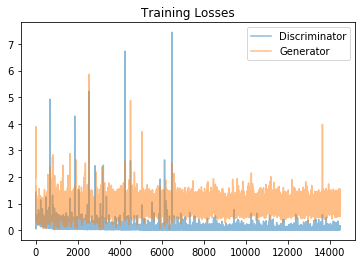

In [23]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [24]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [25]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

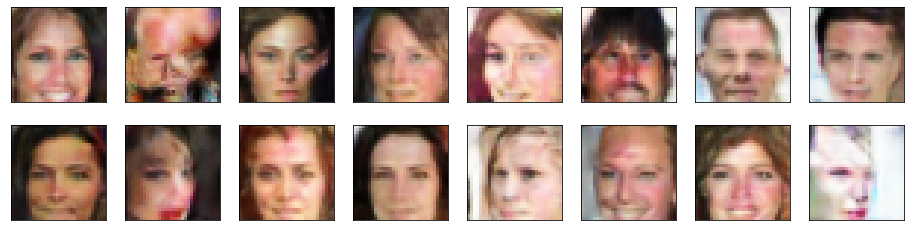

In [26]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.